In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
data = pd.read_csv('ETH_1H.csv',parse_dates=['Date'],index_col=['Date'])

In [3]:
data.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2020-04-16 00:00:00,1586995200000,ETHUSD,152.94,152.94,150.39,150.39,650.188125
2020-04-15 23:00:00,1586991600000,ETHUSD,155.81,155.81,151.39,152.94,4277.567299
2020-04-15 22:00:00,1586988000000,ETHUSD,157.18,157.30,155.32,155.81,106.337279
2020-04-15 21:00:00,1586984400000,ETHUSD,158.04,158.31,157.16,157.18,55.244131
2020-04-15 20:00:00,1586980800000,ETHUSD,157.10,158.10,156.87,158.04,144.262622


In [4]:
data = data.sort_index()

In [5]:
data.shape

(34497, 7)

In [7]:
#checkiing null value
data.isna().sum()

Unix Timestamp    0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
data = data.drop(columns=['Unix Timestamp','Symbol'])

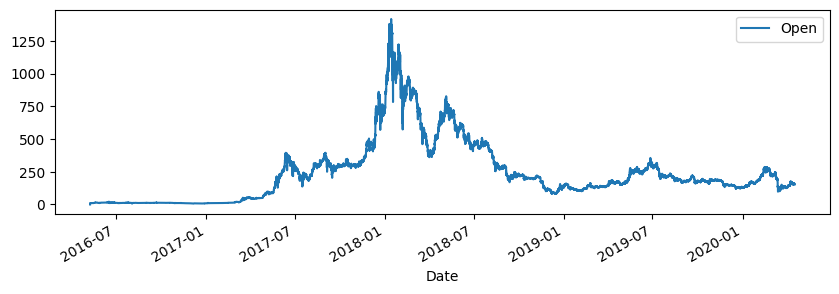

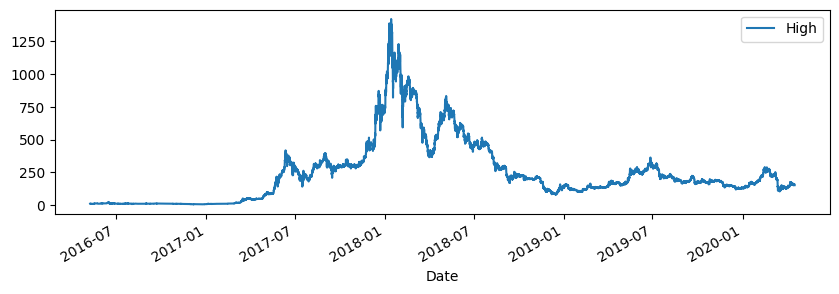

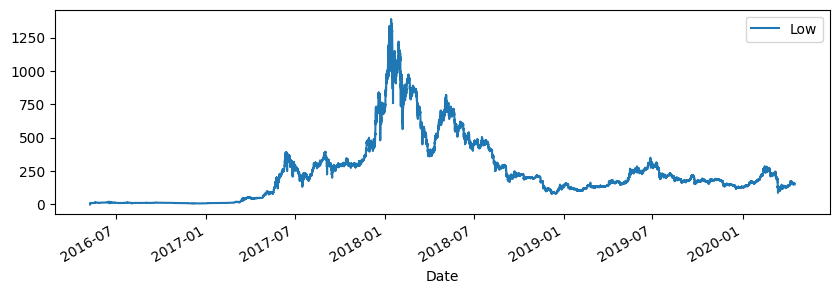

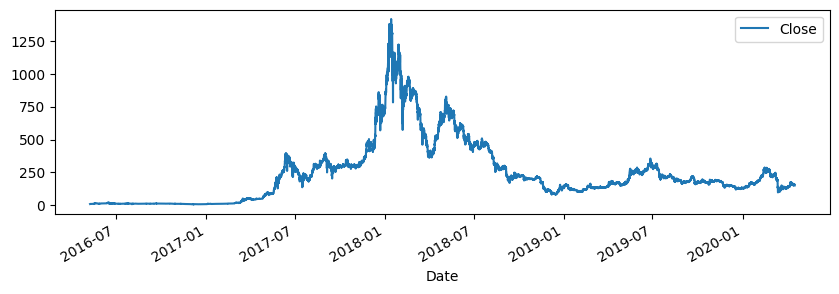

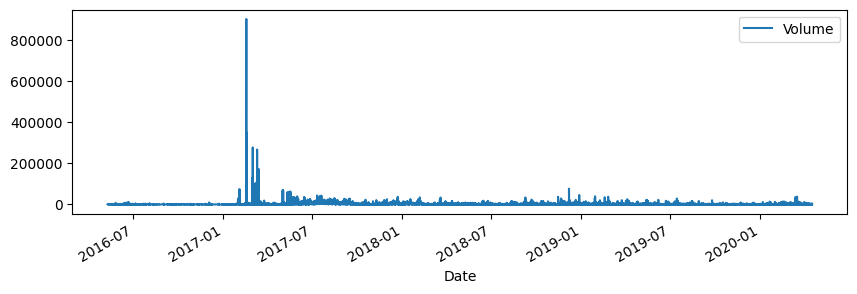

In [10]:
for i in data:
    plt.figure(figsize=(10,3))
    data[i].plot(legend=i)
    plt.show()

In [12]:
#creating the datatime features
def create_f(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

In [13]:
df = create_f(data)

In [14]:
df.head()

,Open,High,Low,Close,Volume,hour,day,month,year,dayofweek,dayofyear,weekofyear
Date,,,,,,,,,,,,
2016-05-09 13:00:00,0.00,12.00,0.00,9.55,432.562115,13,9,5,2016,0,130,19
2016-05-09 14:00:00,9.55,10.00,9.55,10.00,235.774075,14,9,5,2016,0,130,19
2016-05-09 15:00:00,10.00,10.00,9.99,9.99,10.973567,15,9,5,2016,0,130,19
2016-05-09 16:00:00,9.99,9.99,9.79,9.83,62.379450,16,9,5,2016,0,130,19
2016-05-09 17:00:00,9.83,9.83,9.48,9.49,329.553213,17,9,5,2016,0,130,19


<Axes: >

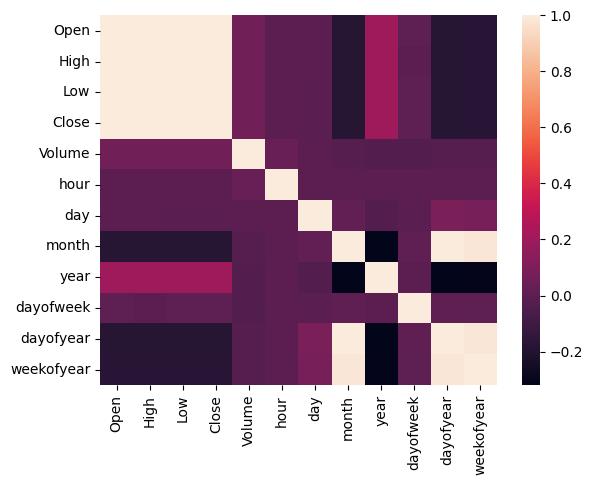

In [15]:
#correlation
sns.heatmap(df.corr())

In [17]:
#generating windows 
# 24 hour window to predict 25th hour using only close

close = df.iloc[:,3] # whole Close Column
windows = []
target = []
length = 240  # means 24 hr
for i in (range(len(close)-length)):
    x = close.iloc[i:i+length] # 0-240
    y = close.iloc[i+length] #241th
    windows.append(x)
    target.append(y)

windows = np.array(windows)
target = np.array(target).reshape(-1,1) #single column and multiple rows

In [18]:
# creating Train & Test Data
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
windows_sc = sc.fit_transform(windows)
target_sc = sc.fit_transform(target)

windows_sc = windows_sc.reshape(len(windows_sc),length,1)

In [19]:
split = int(0.8*len(windows_sc))
X_train = windows_sc[:split,:,:]
X_test = windows_sc[split:,:,:]
y_train = target_sc[:split,:]
y_test = target_sc[split:,:]

In [20]:
print(X_train.shape,y_train.shape)

(27405, 240, 1) (27405, 1)


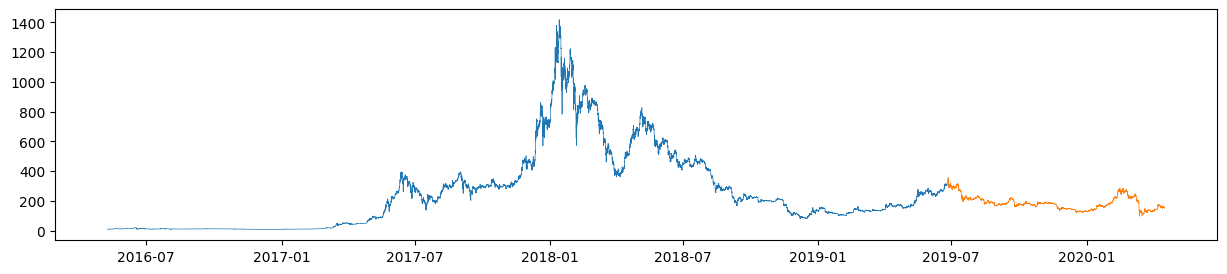

In [21]:
plt.figure(figsize=(15,3))
plt.plot(df['Close'][:split],label='Train',linewidth=0.5)
plt.plot(df['Close'][split:],label='Test',linewidth=0.5)

### Model Building and Training

In [23]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from sklearn.metrics import *

In [24]:
model = Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
model.fit(X_train,y_train, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
275/275 [==============================] - 181s 631ms/step - loss: 0.0010
Epoch 2/5
275/275 [==============================] - 179s 652ms/step - loss: 2.5028e-04
Epoch 3/5
275/275 [==============================] - 170s 616ms/step - loss: 2.2372e-04
Epoch 4/5
275/275 [==============================] - 141s 512ms/step - loss: 2.1472e-04
Epoch 5/5
275/275 [==============================] - 123s 446ms/step - loss: 1.8816e-04


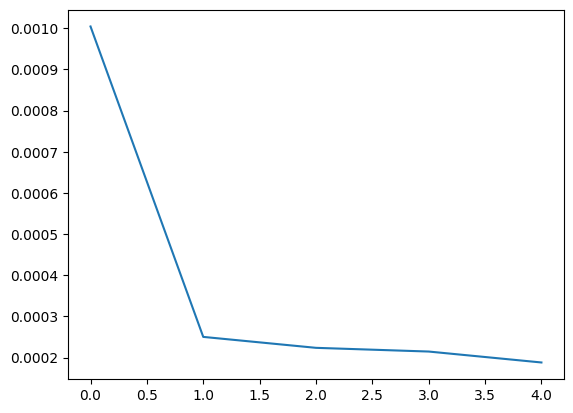

In [28]:
plt.plot(model.history.history['loss'])

In [29]:
pred_sc = model.predict(X_test)
pred = sc.inverse_transform(pred_sc)
y_test_ic = sc.inverse_transform(y_test)

215/215 [==============================] - 17s 73ms/step


The Coefficient of determination (R-squared) = 0.993


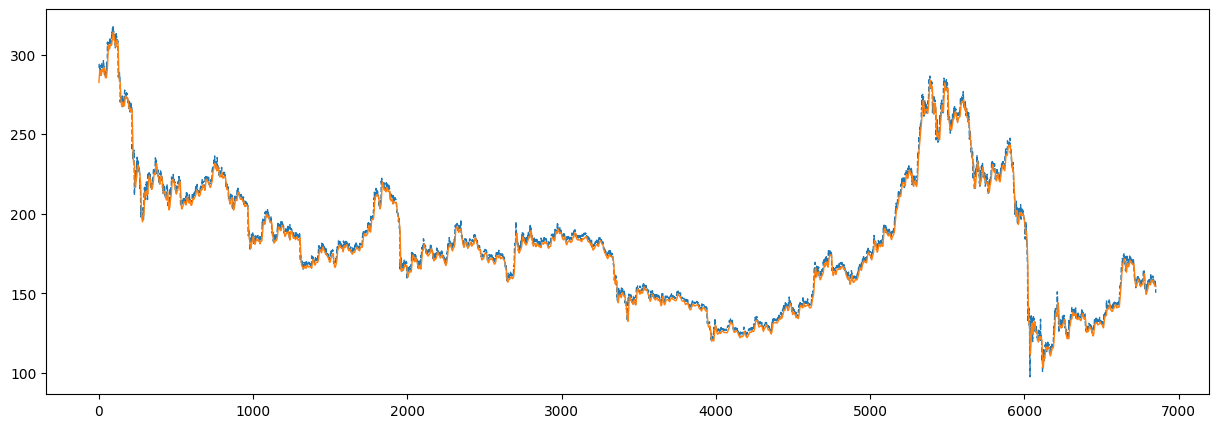

In [30]:
print('The Coefficient of determination (R-squared) = {:.3f}'.format(r2_score(pred,y_test_ic)))

plt.figure(figsize=(15,5))
plt.plot(y_test_ic,'--',label='Actual',linewidth=1)
plt.plot(pred,label='Predicted',linewidth=1)

# Future prediction

In [31]:
model = Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [32]:
#training on entire dataset

X = windows_sc
y = target_sc

model.fit(X,y, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
343/343 [==============================] - 132s 370ms/step - loss: 0.0011
Epoch 2/5
343/343 [==============================] - 126s 367ms/step - loss: 2.3214e-04
Epoch 3/5
343/343 [==============================] - 125s 365ms/step - loss: 1.9547e-04
Epoch 4/5
343/343 [==============================] - 121s 352ms/step - loss: 1.7244e-04
Epoch 5/5
343/343 [==============================] - 123s 358ms/step - loss: 1.5193e-04


In [40]:
from datetime import datetime
from tqdm import tqdm

str_d1 = '2019/04/16'
str_d2 = '2019/06/16'

# convert string to date object
d1 = datetime.strptime(str_d1, "%Y/%m/%d")
d2 = datetime.strptime(str_d2, "%Y/%m/%d")

delta = d2-d1
steps_in_future = delta.days * 24
print("Steps in future: ",steps_in_future)


Steps in future:  1464


In [41]:
#iterative prediction of each future step

f_wind=windows_sc[-1]
f_tar=target_sc[-1]
new=[]

for i in tqdm(range(steps_in_future)):
    curr = np.append(f_wind[1:],[f_tar]).reshape(-1,1)
    #print(curr,end="\n\n")
    next_pred = model.predict(curr.reshape(1,length,1))
    #pred_ic = sc.inverse_transform(next_pred)
    new.append(next_pred[0][0])
    f_wind = curr
    f_tar=next_pred

  0%|                                                                                         | 0/1464 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  0%|                                                                                 | 1/1464 [00:00<03:11,  7.63it/s]

1/1 [==============================] - 0s 50ms/step


  0%|                                                                                 | 2/1464 [00:00<03:02,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


  0%|▏                                                                                | 3/1464 [00:00<02:56,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


  0%|▏                                                                                | 4/1464 [00:00<02:56,  8.25it/s]

1/1 [==============================] - 0s 47ms/step


  0%|▎                                                                                | 5/1464 [00:00<02:56,  8.29it/s]

1/1 [==============================] - 0s 58ms/step


  0%|▎                                                                                | 6/1464 [00:00<03:04,  7.90it/s]

1/1 [==============================] - 0s 56ms/step


  0%|▍                                                                                | 7/1464 [00:00<03:07,  7.78it/s]

1/1 [==============================] - 0s 55ms/step


  1%|▍                                                                                | 8/1464 [00:00<03:02,  7.99it/s]

1/1 [==============================] - 0s 57ms/step


  1%|▍                                                                                | 9/1464 [00:01<03:09,  7.66it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▌                                                                               | 10/1464 [00:01<03:26,  7.06it/s]

1/1 [==============================] - 0s 78ms/step


  1%|▌                                                                               | 11/1464 [00:01<03:41,  6.55it/s]

1/1 [==============================] - 0s 77ms/step


  1%|▋                                                                               | 12/1464 [00:01<03:52,  6.24it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▋                                                                               | 13/1464 [00:01<03:41,  6.55it/s]

1/1 [==============================] - 0s 50ms/step


  1%|▊                                                                               | 14/1464 [00:01<03:27,  6.99it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▊                                                                               | 15/1464 [00:02<03:30,  6.89it/s]

1/1 [==============================] - 0s 55ms/step


  1%|▊                                                                               | 16/1464 [00:02<03:24,  7.09it/s]

1/1 [==============================] - 0s 50ms/step


  1%|▉                                                                               | 17/1464 [00:02<03:12,  7.52it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▉                                                                               | 18/1464 [00:02<03:03,  7.86it/s]

1/1 [==============================] - 0s 47ms/step


  1%|█                                                                               | 19/1464 [00:02<02:59,  8.06it/s]

1/1 [==============================] - 0s 52ms/step


  1%|█                                                                               | 20/1464 [00:02<02:53,  8.31it/s]

1/1 [==============================] - 0s 55ms/step


  1%|█▏                                                                              | 21/1464 [00:02<02:56,  8.18it/s]

1/1 [==============================] - 0s 55ms/step


  2%|█▏                                                                              | 22/1464 [00:02<02:54,  8.24it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▎                                                                              | 23/1464 [00:03<02:55,  8.20it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▎                                                                              | 24/1464 [00:03<02:56,  8.17it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▎                                                                              | 25/1464 [00:03<02:50,  8.42it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▍                                                                              | 26/1464 [00:03<02:43,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▍                                                                              | 27/1464 [00:03<02:44,  8.75it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▌                                                                              | 28/1464 [00:03<02:39,  8.99it/s]

1/1 [==============================] - 0s 59ms/step


  2%|█▌                                                                              | 29/1464 [00:03<02:41,  8.90it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▋                                                                              | 30/1464 [00:03<02:37,  9.09it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▋                                                                              | 31/1464 [00:03<02:36,  9.14it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▋                                                                              | 32/1464 [00:04<02:34,  9.26it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▊                                                                              | 33/1464 [00:04<02:32,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▊                                                                              | 34/1464 [00:04<02:31,  9.45it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                              | 35/1464 [00:04<02:31,  9.43it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                              | 36/1464 [00:04<02:29,  9.56it/s]

1/1 [==============================] - 0s 50ms/step


  3%|██                                                                              | 37/1464 [00:04<02:31,  9.44it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██                                                                              | 38/1464 [00:04<02:31,  9.43it/s]

1/1 [==============================] - 0s 59ms/step


  3%|██▏                                                                             | 39/1464 [00:04<02:44,  8.64it/s]

1/1 [==============================] - 0s 54ms/step


  3%|██▏                                                                             | 40/1464 [00:04<02:44,  8.66it/s]

1/1 [==============================] - 0s 55ms/step


  3%|██▏                                                                             | 41/1464 [00:05<02:51,  8.30it/s]

1/1 [==============================] - 0s 56ms/step


  3%|██▎                                                                             | 42/1464 [00:05<02:54,  8.14it/s]

1/1 [==============================] - 0s 60ms/step


  3%|██▎                                                                             | 43/1464 [00:05<02:58,  7.96it/s]

1/1 [==============================] - 0s 60ms/step


  3%|██▍                                                                             | 44/1464 [00:05<03:02,  7.76it/s]

1/1 [==============================] - 0s 62ms/step


  3%|██▍                                                                             | 45/1464 [00:05<03:05,  7.64it/s]

1/1 [==============================] - 0s 57ms/step


  3%|██▌                                                                             | 46/1464 [00:05<03:06,  7.60it/s]

1/1 [==============================] - 0s 56ms/step


  3%|██▌                                                                             | 47/1464 [00:05<03:06,  7.60it/s]

1/1 [==============================] - 0s 57ms/step


  3%|██▌                                                                             | 48/1464 [00:05<03:07,  7.56it/s]

1/1 [==============================] - 0s 49ms/step


  3%|██▋                                                                             | 49/1464 [00:06<03:03,  7.70it/s]

1/1 [==============================] - 0s 42ms/step


  3%|██▋                                                                             | 50/1464 [00:06<02:53,  8.16it/s]

1/1 [==============================] - 0s 50ms/step


  3%|██▊                                                                             | 51/1464 [00:06<02:48,  8.39it/s]

1/1 [==============================] - 0s 47ms/step


  4%|██▊                                                                             | 52/1464 [00:06<02:44,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


  4%|██▉                                                                             | 53/1464 [00:06<02:40,  8.79it/s]

1/1 [==============================] - 0s 49ms/step


  4%|██▉                                                                             | 54/1464 [00:06<02:35,  9.08it/s]

1/1 [==============================] - 0s 52ms/step


  4%|███                                                                             | 55/1464 [00:06<02:33,  9.19it/s]

1/1 [==============================] - 0s 49ms/step


  4%|███                                                                             | 56/1464 [00:06<02:33,  9.20it/s]

1/1 [==============================] - 0s 50ms/step


  4%|███                                                                             | 57/1464 [00:06<02:29,  9.38it/s]

1/1 [==============================] - 0s 51ms/step


  4%|███▏                                                                            | 58/1464 [00:07<02:33,  9.17it/s]

1/1 [==============================] - 0s 53ms/step


  4%|███▏                                                                            | 59/1464 [00:07<02:39,  8.81it/s]

1/1 [==============================] - 0s 61ms/step


  4%|███▎                                                                            | 60/1464 [00:07<02:44,  8.52it/s]

1/1 [==============================] - 0s 55ms/step


  4%|███▎                                                                            | 61/1464 [00:07<02:44,  8.53it/s]

1/1 [==============================] - 0s 64ms/step


  4%|███▍                                                                            | 62/1464 [00:07<02:52,  8.13it/s]

1/1 [==============================] - 0s 59ms/step


  4%|███▍                                                                            | 63/1464 [00:07<02:56,  7.93it/s]

1/1 [==============================] - 0s 48ms/step


  4%|███▍                                                                            | 64/1464 [00:07<02:47,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


  4%|███▌                                                                            | 65/1464 [00:07<02:40,  8.71it/s]

1/1 [==============================] - 0s 55ms/step


  5%|███▌                                                                            | 66/1464 [00:08<02:43,  8.53it/s]

1/1 [==============================] - 0s 52ms/step


  5%|███▋                                                                            | 67/1464 [00:08<02:45,  8.43it/s]

1/1 [==============================] - 0s 52ms/step


  5%|███▋                                                                            | 68/1464 [00:08<02:45,  8.45it/s]

1/1 [==============================] - 0s 75ms/step


  5%|███▊                                                                            | 69/1464 [00:08<02:58,  7.79it/s]

1/1 [==============================] - 0s 57ms/step


  5%|███▊                                                                            | 70/1464 [00:08<03:06,  7.47it/s]

1/1 [==============================] - 0s 50ms/step


  5%|███▉                                                                            | 71/1464 [00:08<03:02,  7.63it/s]

1/1 [==============================] - 0s 53ms/step


  5%|███▉                                                                            | 72/1464 [00:08<02:55,  7.95it/s]

1/1 [==============================] - 0s 63ms/step


  5%|███▉                                                                            | 73/1464 [00:08<02:53,  8.03it/s]

1/1 [==============================] - 0s 64ms/step


  5%|████                                                                            | 74/1464 [00:09<02:58,  7.80it/s]

1/1 [==============================] - 0s 55ms/step


  5%|████                                                                            | 75/1464 [00:09<02:57,  7.81it/s]

1/1 [==============================] - 0s 56ms/step


  5%|████▏                                                                           | 76/1464 [00:09<02:55,  7.89it/s]

1/1 [==============================] - 0s 47ms/step


  5%|████▏                                                                           | 77/1464 [00:09<02:53,  8.01it/s]

1/1 [==============================] - 0s 47ms/step


  5%|████▎                                                                           | 78/1464 [00:09<02:45,  8.40it/s]

1/1 [==============================] - 0s 53ms/step


  5%|████▎                                                                           | 79/1464 [00:09<02:42,  8.54it/s]

1/1 [==============================] - 0s 65ms/step


  5%|████▎                                                                           | 80/1464 [00:09<03:25,  6.73it/s]

1/1 [==============================] - 0s 57ms/step


  6%|████▍                                                                           | 81/1464 [00:10<03:24,  6.76it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████▍                                                                           | 82/1464 [00:10<03:13,  7.14it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▌                                                                           | 83/1464 [00:10<03:05,  7.45it/s]

1/1 [==============================] - 0s 69ms/step


  6%|████▌                                                                           | 84/1464 [00:10<03:05,  7.45it/s]

1/1 [==============================] - 0s 63ms/step


  6%|████▋                                                                           | 85/1464 [00:10<03:08,  7.33it/s]

1/1 [==============================] - 0s 49ms/step


  6%|████▋                                                                           | 86/1464 [00:10<02:58,  7.74it/s]

1/1 [==============================] - 0s 54ms/step


  6%|████▊                                                                           | 87/1464 [00:10<02:54,  7.90it/s]

1/1 [==============================] - 0s 47ms/step


  6%|████▊                                                                           | 88/1464 [00:10<02:48,  8.15it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████▊                                                                           | 89/1464 [00:10<02:42,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████▉                                                                           | 90/1464 [00:11<02:40,  8.54it/s]

1/1 [==============================] - 0s 53ms/step


  6%|████▉                                                                           | 91/1464 [00:11<02:41,  8.49it/s]

1/1 [==============================] - 0s 59ms/step


  6%|█████                                                                           | 92/1464 [00:11<02:46,  8.25it/s]

1/1 [==============================] - 0s 57ms/step


  6%|█████                                                                           | 93/1464 [00:11<02:50,  8.02it/s]

1/1 [==============================] - 0s 53ms/step


  6%|█████▏                                                                          | 94/1464 [00:11<02:47,  8.16it/s]

1/1 [==============================] - 0s 53ms/step


  6%|█████▏                                                                          | 95/1464 [00:11<02:47,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


  7%|█████▏                                                                          | 96/1464 [00:11<02:47,  8.15it/s]

1/1 [==============================] - 0s 133ms/step


  7%|█████▎                                                                          | 97/1464 [00:12<03:28,  6.55it/s]

1/1 [==============================] - 0s 115ms/step


  7%|█████▎                                                                          | 98/1464 [00:12<05:09,  4.41it/s]

1/1 [==============================] - 0s 63ms/step


  7%|█████▍                                                                          | 99/1464 [00:12<04:31,  5.03it/s]

1/1 [==============================] - 0s 68ms/step


  7%|█████▍                                                                         | 100/1464 [00:12<04:05,  5.55it/s]

1/1 [==============================] - 0s 85ms/step


  7%|█████▍                                                                         | 101/1464 [00:12<03:54,  5.82it/s]

1/1 [==============================] - 0s 59ms/step


  7%|█████▌                                                                         | 102/1464 [00:13<03:35,  6.31it/s]

1/1 [==============================] - 0s 64ms/step


  7%|█████▌                                                                         | 103/1464 [00:13<03:26,  6.58it/s]

1/1 [==============================] - 0s 55ms/step


  7%|█████▌                                                                         | 104/1464 [00:13<03:17,  6.89it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▋                                                                         | 105/1464 [00:13<04:27,  5.08it/s]

1/1 [==============================] - 0s 68ms/step


  7%|█████▋                                                                         | 106/1464 [00:13<04:19,  5.23it/s]

1/1 [==============================] - 0s 50ms/step


  7%|█████▊                                                                         | 107/1464 [00:13<03:50,  5.88it/s]

1/1 [==============================] - 0s 86ms/step


  7%|█████▊                                                                         | 108/1464 [00:14<03:45,  6.02it/s]

1/1 [==============================] - 0s 54ms/step


  7%|█████▉                                                                         | 109/1464 [00:14<03:26,  6.55it/s]

1/1 [==============================] - 0s 53ms/step


  8%|█████▉                                                                         | 110/1464 [00:14<03:10,  7.12it/s]

1/1 [==============================] - 0s 54ms/step


  8%|█████▉                                                                         | 111/1464 [00:14<03:01,  7.45it/s]

1/1 [==============================] - 0s 51ms/step


  8%|██████                                                                         | 112/1464 [00:14<02:53,  7.80it/s]

1/1 [==============================] - 0s 56ms/step


  8%|██████                                                                         | 113/1464 [00:14<02:51,  7.90it/s]

1/1 [==============================] - 0s 60ms/step


  8%|██████▏                                                                        | 114/1464 [00:14<02:48,  8.00it/s]

1/1 [==============================] - 0s 67ms/step


  8%|██████▏                                                                        | 115/1464 [00:14<03:11,  7.03it/s]

1/1 [==============================] - 0s 57ms/step


  8%|██████▎                                                                        | 116/1464 [00:15<03:10,  7.07it/s]

1/1 [==============================] - 0s 72ms/step


  8%|██████▎                                                                        | 117/1464 [00:15<03:12,  6.98it/s]

1/1 [==============================] - 0s 78ms/step


  8%|██████▎                                                                        | 118/1464 [00:15<03:22,  6.66it/s]

1/1 [==============================] - 0s 161ms/step


  8%|██████▍                                                                        | 119/1464 [00:15<04:02,  5.56it/s]

1/1 [==============================] - 0s 81ms/step


  8%|██████▍                                                                        | 120/1464 [00:15<03:55,  5.71it/s]

1/1 [==============================] - 0s 77ms/step


  8%|██████▌                                                                        | 121/1464 [00:15<03:53,  5.74it/s]

1/1 [==============================] - 0s 75ms/step


  8%|██████▌                                                                        | 122/1464 [00:16<03:43,  6.00it/s]

1/1 [==============================] - 0s 47ms/step


  8%|██████▋                                                                        | 123/1464 [00:16<03:29,  6.40it/s]

1/1 [==============================] - 0s 48ms/step


  8%|██████▋                                                                        | 124/1464 [00:16<03:13,  6.91it/s]

1/1 [==============================] - 0s 45ms/step


  9%|██████▋                                                                        | 125/1464 [00:16<02:59,  7.44it/s]

1/1 [==============================] - 0s 50ms/step


  9%|██████▊                                                                        | 126/1464 [00:16<02:50,  7.86it/s]

1/1 [==============================] - 0s 55ms/step


  9%|██████▊                                                                        | 127/1464 [00:16<02:44,  8.10it/s]

1/1 [==============================] - 0s 54ms/step


  9%|██████▉                                                                        | 128/1464 [00:16<02:41,  8.27it/s]

1/1 [==============================] - 0s 55ms/step


  9%|██████▉                                                                        | 129/1464 [00:16<02:47,  7.98it/s]

1/1 [==============================] - 0s 53ms/step


  9%|███████                                                                        | 130/1464 [00:17<02:47,  7.98it/s]

1/1 [==============================] - 0s 60ms/step


  9%|███████                                                                        | 131/1464 [00:17<02:45,  8.04it/s]

1/1 [==============================] - 0s 54ms/step


  9%|███████                                                                        | 132/1464 [00:17<02:44,  8.10it/s]

1/1 [==============================] - 0s 59ms/step


  9%|███████▏                                                                       | 133/1464 [00:17<02:46,  7.99it/s]

1/1 [==============================] - 0s 54ms/step


  9%|███████▏                                                                       | 134/1464 [00:17<02:44,  8.11it/s]

1/1 [==============================] - 0s 55ms/step


  9%|███████▎                                                                       | 135/1464 [00:17<02:41,  8.24it/s]

1/1 [==============================] - 0s 49ms/step


  9%|███████▎                                                                       | 136/1464 [00:17<02:36,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


  9%|███████▍                                                                       | 137/1464 [00:17<02:32,  8.73it/s]

1/1 [==============================] - 0s 53ms/step


  9%|███████▍                                                                       | 138/1464 [00:18<02:29,  8.86it/s]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                       | 139/1464 [00:18<02:28,  8.92it/s]

1/1 [==============================] - 0s 52ms/step


 10%|███████▌                                                                       | 140/1464 [00:18<02:31,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 10%|███████▌                                                                       | 141/1464 [00:18<02:27,  8.97it/s]

1/1 [==============================] - 0s 54ms/step


 10%|███████▋                                                                       | 142/1464 [00:18<02:31,  8.72it/s]

1/1 [==============================] - 0s 52ms/step


 10%|███████▋                                                                       | 143/1464 [00:18<02:32,  8.69it/s]

1/1 [==============================] - 0s 53ms/step


 10%|███████▊                                                                       | 144/1464 [00:18<02:32,  8.67it/s]

1/1 [==============================] - 0s 53ms/step


 10%|███████▊                                                                       | 145/1464 [00:18<02:32,  8.66it/s]

1/1 [==============================] - 0s 54ms/step


 10%|███████▉                                                                       | 146/1464 [00:18<02:30,  8.74it/s]

1/1 [==============================] - 0s 55ms/step


 10%|███████▉                                                                       | 147/1464 [00:19<02:31,  8.71it/s]

1/1 [==============================] - 0s 50ms/step


 10%|███████▉                                                                       | 148/1464 [00:19<02:29,  8.78it/s]

1/1 [==============================] - 0s 50ms/step


 10%|████████                                                                       | 149/1464 [00:19<02:28,  8.83it/s]

1/1 [==============================] - 0s 55ms/step


 10%|████████                                                                       | 150/1464 [00:19<02:30,  8.73it/s]

1/1 [==============================] - 0s 53ms/step


 10%|████████▏                                                                      | 151/1464 [00:19<02:35,  8.47it/s]

1/1 [==============================] - 0s 54ms/step


 10%|████████▏                                                                      | 152/1464 [00:19<02:32,  8.59it/s]

1/1 [==============================] - 0s 46ms/step


 10%|████████▎                                                                      | 153/1464 [00:19<02:28,  8.85it/s]

1/1 [==============================] - 0s 48ms/step


 11%|████████▎                                                                      | 154/1464 [00:19<02:26,  8.94it/s]

1/1 [==============================] - 0s 50ms/step


 11%|████████▎                                                                      | 155/1464 [00:19<02:28,  8.83it/s]

1/1 [==============================] - 0s 57ms/step


 11%|████████▍                                                                      | 156/1464 [00:20<02:31,  8.64it/s]

1/1 [==============================] - 0s 54ms/step


 11%|████████▍                                                                      | 157/1464 [00:20<02:31,  8.64it/s]

1/1 [==============================] - 0s 51ms/step


 11%|████████▌                                                                      | 158/1464 [00:20<02:26,  8.91it/s]

1/1 [==============================] - 0s 50ms/step


 11%|████████▌                                                                      | 159/1464 [00:20<02:23,  9.07it/s]

1/1 [==============================] - 0s 50ms/step


 11%|████████▋                                                                      | 160/1464 [00:20<02:27,  8.85it/s]

1/1 [==============================] - 0s 51ms/step


 11%|████████▋                                                                      | 161/1464 [00:20<02:27,  8.86it/s]

1/1 [==============================] - 0s 57ms/step


 11%|████████▋                                                                      | 162/1464 [00:20<02:27,  8.85it/s]

1/1 [==============================] - 0s 54ms/step


 11%|████████▊                                                                      | 163/1464 [00:20<02:27,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


 11%|████████▊                                                                      | 164/1464 [00:21<02:32,  8.53it/s]

1/1 [==============================] - 0s 58ms/step


 11%|████████▉                                                                      | 165/1464 [00:21<02:36,  8.29it/s]

1/1 [==============================] - 0s 59ms/step


 11%|████████▉                                                                      | 166/1464 [00:21<02:40,  8.06it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█████████                                                                      | 167/1464 [00:21<02:35,  8.35it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█████████                                                                      | 168/1464 [00:21<02:32,  8.49it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█████████                                                                      | 169/1464 [00:21<02:31,  8.53it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█████████▏                                                                     | 170/1464 [00:21<02:33,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▏                                                                     | 171/1464 [00:21<02:29,  8.67it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█████████▎                                                                     | 172/1464 [00:21<02:30,  8.59it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█████████▎                                                                     | 173/1464 [00:22<02:29,  8.62it/s]

1/1 [==============================] - 0s 53ms/step


 12%|█████████▍                                                                     | 174/1464 [00:22<02:29,  8.60it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▍                                                                     | 175/1464 [00:22<02:28,  8.69it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█████████▍                                                                     | 176/1464 [00:22<02:25,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█████████▌                                                                     | 177/1464 [00:22<02:23,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▌                                                                     | 178/1464 [00:22<02:25,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█████████▋                                                                     | 179/1464 [00:22<02:21,  9.07it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█████████▋                                                                     | 180/1464 [00:22<02:23,  8.98it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█████████▊                                                                     | 181/1464 [00:22<02:20,  9.11it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█████████▊                                                                     | 182/1464 [00:23<02:22,  9.00it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█████████▉                                                                     | 183/1464 [00:23<02:23,  8.91it/s]

1/1 [==============================] - 0s 53ms/step


 13%|█████████▉                                                                     | 184/1464 [00:23<02:23,  8.93it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█████████▉                                                                     | 185/1464 [00:23<02:22,  8.97it/s]

1/1 [==============================] - 0s 55ms/step


 13%|██████████                                                                     | 186/1464 [00:23<02:24,  8.83it/s]

1/1 [==============================] - 0s 48ms/step


 13%|██████████                                                                     | 187/1464 [00:23<02:28,  8.57it/s]

1/1 [==============================] - 0s 56ms/step


 13%|██████████▏                                                                    | 188/1464 [00:23<02:27,  8.68it/s]

1/1 [==============================] - 0s 50ms/step


 13%|██████████▏                                                                    | 189/1464 [00:23<02:24,  8.80it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▎                                                                    | 190/1464 [00:23<02:23,  8.85it/s]

1/1 [==============================] - 0s 56ms/step


 13%|██████████▎                                                                    | 191/1464 [00:24<02:25,  8.74it/s]

1/1 [==============================] - 0s 55ms/step


 13%|██████████▎                                                                    | 192/1464 [00:24<02:23,  8.88it/s]

1/1 [==============================] - 0s 55ms/step


 13%|██████████▍                                                                    | 193/1464 [00:24<02:24,  8.78it/s]

1/1 [==============================] - 0s 53ms/step


 13%|██████████▍                                                                    | 194/1464 [00:24<02:27,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 13%|██████████▌                                                                    | 195/1464 [00:24<02:25,  8.74it/s]

1/1 [==============================] - 0s 52ms/step


 13%|██████████▌                                                                    | 196/1464 [00:24<02:27,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


 13%|██████████▋                                                                    | 197/1464 [00:24<02:22,  8.86it/s]

1/1 [==============================] - 0s 63ms/step


 14%|██████████▋                                                                    | 198/1464 [00:24<02:26,  8.64it/s]

1/1 [==============================] - 0s 54ms/step


 14%|██████████▋                                                                    | 199/1464 [00:25<02:27,  8.59it/s]

1/1 [==============================] - 0s 53ms/step


 14%|██████████▊                                                                    | 200/1464 [00:25<02:24,  8.76it/s]

1/1 [==============================] - 0s 54ms/step


 14%|██████████▊                                                                    | 201/1464 [00:25<02:24,  8.75it/s]

1/1 [==============================] - 0s 53ms/step


 14%|██████████▉                                                                    | 202/1464 [00:25<02:22,  8.83it/s]

1/1 [==============================] - 0s 48ms/step


 14%|██████████▉                                                                    | 203/1464 [00:25<02:20,  8.99it/s]

1/1 [==============================] - 0s 48ms/step


 14%|███████████                                                                    | 204/1464 [00:25<02:17,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 14%|███████████                                                                    | 205/1464 [00:25<02:19,  9.00it/s]

1/1 [==============================] - 0s 47ms/step


 14%|███████████                                                                    | 206/1464 [00:25<02:17,  9.12it/s]

1/1 [==============================] - 0s 56ms/step


 14%|███████████▏                                                                   | 207/1464 [00:25<02:19,  9.00it/s]

1/1 [==============================] - 0s 54ms/step


 14%|███████████▏                                                                   | 208/1464 [00:26<02:19,  9.03it/s]

1/1 [==============================] - 0s 55ms/step


 14%|███████████▎                                                                   | 209/1464 [00:26<02:27,  8.53it/s]

1/1 [==============================] - 0s 57ms/step


 14%|███████████▎                                                                   | 210/1464 [00:26<02:31,  8.28it/s]

1/1 [==============================] - 0s 56ms/step


 14%|███████████▍                                                                   | 211/1464 [00:26<02:36,  8.03it/s]

1/1 [==============================] - 0s 57ms/step


 14%|███████████▍                                                                   | 212/1464 [00:26<02:29,  8.35it/s]

1/1 [==============================] - 0s 52ms/step


 15%|███████████▍                                                                   | 213/1464 [00:26<02:27,  8.48it/s]

1/1 [==============================] - 0s 56ms/step


 15%|███████████▌                                                                   | 214/1464 [00:26<02:28,  8.40it/s]

1/1 [==============================] - 0s 47ms/step


 15%|███████████▌                                                                   | 215/1464 [00:26<02:26,  8.52it/s]

1/1 [==============================] - 0s 66ms/step


 15%|███████████▋                                                                   | 216/1464 [00:26<02:31,  8.21it/s]

1/1 [==============================] - 0s 51ms/step


 15%|███████████▋                                                                   | 217/1464 [00:27<02:26,  8.54it/s]

1/1 [==============================] - 0s 58ms/step


 15%|███████████▊                                                                   | 218/1464 [00:27<02:30,  8.28it/s]

1/1 [==============================] - 0s 53ms/step


 15%|███████████▊                                                                   | 219/1464 [00:27<02:31,  8.24it/s]

1/1 [==============================] - 0s 50ms/step


 15%|███████████▊                                                                   | 220/1464 [00:27<02:27,  8.42it/s]

1/1 [==============================] - 0s 56ms/step


 15%|███████████▉                                                                   | 221/1464 [00:27<02:28,  8.39it/s]

1/1 [==============================] - 0s 53ms/step


 15%|███████████▉                                                                   | 222/1464 [00:27<02:26,  8.45it/s]

1/1 [==============================] - 0s 50ms/step


 15%|████████████                                                                   | 223/1464 [00:27<02:23,  8.66it/s]

1/1 [==============================] - 0s 56ms/step


 15%|████████████                                                                   | 224/1464 [00:27<02:24,  8.58it/s]

1/1 [==============================] - 0s 54ms/step


 15%|████████████▏                                                                  | 225/1464 [00:28<02:23,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 15%|████████████▏                                                                  | 226/1464 [00:28<02:19,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 16%|████████████▏                                                                  | 227/1464 [00:28<02:15,  9.15it/s]

1/1 [==============================] - 0s 51ms/step


 16%|████████████▎                                                                  | 228/1464 [00:28<02:16,  9.03it/s]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▎                                                                  | 229/1464 [00:28<02:29,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


 16%|████████████▍                                                                  | 230/1464 [00:28<02:24,  8.56it/s]

1/1 [==============================] - 0s 47ms/step


 16%|████████████▍                                                                  | 231/1464 [00:28<02:18,  8.90it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▌                                                                  | 232/1464 [00:28<02:22,  8.66it/s]

1/1 [==============================] - 0s 51ms/step


 16%|████████████▌                                                                  | 233/1464 [00:28<02:21,  8.69it/s]

1/1 [==============================] - 0s 44ms/step


 16%|████████████▋                                                                  | 234/1464 [00:29<02:18,  8.90it/s]

1/1 [==============================] - 0s 52ms/step


 16%|████████████▋                                                                  | 235/1464 [00:29<02:15,  9.05it/s]

1/1 [==============================] - 0s 50ms/step


 16%|████████████▋                                                                  | 236/1464 [00:29<02:15,  9.05it/s]

1/1 [==============================] - 0s 52ms/step


 16%|████████████▊                                                                  | 237/1464 [00:29<02:18,  8.88it/s]

1/1 [==============================] - 0s 53ms/step


 16%|████████████▊                                                                  | 238/1464 [00:29<02:16,  8.99it/s]

1/1 [==============================] - 0s 57ms/step


 16%|████████████▉                                                                  | 239/1464 [00:29<02:17,  8.92it/s]

1/1 [==============================] - 0s 62ms/step


 16%|████████████▉                                                                  | 240/1464 [00:29<02:20,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████                                                                  | 241/1464 [00:29<02:20,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█████████████                                                                  | 242/1464 [00:30<02:35,  7.85it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█████████████                                                                  | 243/1464 [00:30<02:29,  8.19it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█████████████▏                                                                 | 244/1464 [00:30<02:25,  8.41it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▏                                                                 | 245/1464 [00:30<02:22,  8.56it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█████████████▎                                                                 | 246/1464 [00:30<02:19,  8.71it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████▍                                                                 | 248/1464 [00:30<02:12,  9.15it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█████████████▍                                                                 | 249/1464 [00:30<02:13,  9.07it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█████████████▍                                                                 | 250/1464 [00:30<02:15,  8.95it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█████████████▌                                                                 | 251/1464 [00:31<02:15,  8.94it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█████████████▌                                                                 | 252/1464 [00:31<02:18,  8.76it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█████████████▋                                                                 | 253/1464 [00:31<02:17,  8.81it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█████████████▋                                                                 | 254/1464 [00:31<02:18,  8.76it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█████████████▊                                                                 | 255/1464 [00:31<02:15,  8.95it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█████████████▊                                                                 | 256/1464 [00:31<02:13,  9.02it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█████████████▊                                                                 | 257/1464 [00:31<02:12,  9.08it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█████████████▉                                                                 | 258/1464 [00:31<02:09,  9.28it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█████████████▉                                                                 | 259/1464 [00:31<02:16,  8.83it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████                                                                 | 260/1464 [00:32<02:17,  8.76it/s]

1/1 [==============================] - 0s 49ms/step


 18%|██████████████                                                                 | 261/1464 [00:32<02:14,  8.95it/s]

1/1 [==============================] - 0s 58ms/step


 18%|██████████████▏                                                                | 262/1464 [00:32<02:14,  8.91it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▏                                                                | 263/1464 [00:32<02:16,  8.80it/s]

1/1 [==============================] - 0s 51ms/step


 18%|██████████████▏                                                                | 264/1464 [00:32<02:12,  9.03it/s]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▎                                                                | 265/1464 [00:32<02:12,  9.07it/s]

1/1 [==============================] - 0s 53ms/step


 18%|██████████████▎                                                                | 266/1464 [00:32<02:14,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


 18%|██████████████▍                                                                | 267/1464 [00:32<02:11,  9.12it/s]

1/1 [==============================] - 0s 59ms/step


 18%|██████████████▍                                                                | 268/1464 [00:32<02:19,  8.55it/s]

1/1 [==============================] - 0s 50ms/step


 18%|██████████████▌                                                                | 269/1464 [00:33<02:17,  8.67it/s]

1/1 [==============================] - 0s 55ms/step


 18%|██████████████▌                                                                | 270/1464 [00:33<02:17,  8.70it/s]

1/1 [==============================] - 0s 55ms/step


 19%|██████████████▌                                                                | 271/1464 [00:33<02:16,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


 19%|██████████████▋                                                                | 272/1464 [00:33<02:13,  8.94it/s]

1/1 [==============================] - 0s 50ms/step


 19%|██████████████▋                                                                | 273/1464 [00:33<02:10,  9.14it/s]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████▊                                                                | 274/1464 [00:33<02:11,  9.03it/s]

1/1 [==============================] - 0s 54ms/step


 19%|██████████████▊                                                                | 275/1464 [00:33<02:11,  9.07it/s]

1/1 [==============================] - 0s 53ms/step


 19%|██████████████▉                                                                | 276/1464 [00:33<02:11,  9.05it/s]

1/1 [==============================] - 0s 54ms/step


 19%|██████████████▉                                                                | 277/1464 [00:33<02:14,  8.85it/s]

1/1 [==============================] - 0s 54ms/step


 19%|███████████████                                                                | 278/1464 [00:34<02:13,  8.91it/s]

1/1 [==============================] - 0s 51ms/step


 19%|███████████████                                                                | 279/1464 [00:34<02:12,  8.97it/s]

1/1 [==============================] - 0s 54ms/step


 19%|███████████████                                                                | 280/1464 [00:34<02:19,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 19%|███████████████▏                                                               | 281/1464 [00:34<02:17,  8.62it/s]

1/1 [==============================] - 0s 56ms/step


 19%|███████████████▏                                                               | 282/1464 [00:34<02:21,  8.35it/s]

1/1 [==============================] - 0s 58ms/step


 19%|███████████████▎                                                               | 283/1464 [00:34<02:22,  8.29it/s]

1/1 [==============================] - 0s 48ms/step


 19%|███████████████▎                                                               | 284/1464 [00:34<02:16,  8.63it/s]

1/1 [==============================] - 0s 49ms/step


 20%|███████████████▍                                                               | 286/1464 [00:34<02:09,  9.09it/s]

1/1 [==============================] - 0s 49ms/step


 20%|███████████████▍                                                               | 287/1464 [00:35<02:10,  8.99it/s]

1/1 [==============================] - 0s 51ms/step


 20%|███████████████▌                                                               | 288/1464 [00:35<02:08,  9.15it/s]

1/1 [==============================] - 0s 58ms/step


 20%|███████████████▌                                                               | 289/1464 [00:35<02:11,  8.95it/s]

1/1 [==============================] - 0s 52ms/step


 20%|███████████████▋                                                               | 290/1464 [00:35<02:12,  8.87it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████████████▋                                                               | 291/1464 [00:35<02:10,  8.97it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████████████▊                                                               | 292/1464 [00:35<02:10,  8.96it/s]

1/1 [==============================] - 0s 51ms/step


 20%|███████████████▊                                                               | 293/1464 [00:35<02:10,  8.98it/s]

1/1 [==============================] - 0s 52ms/step


 20%|███████████████▊                                                               | 294/1464 [00:35<02:10,  8.95it/s]

1/1 [==============================] - 0s 50ms/step


 20%|███████████████▉                                                               | 295/1464 [00:35<02:11,  8.87it/s]

1/1 [==============================] - 0s 48ms/step


 20%|███████████████▉                                                               | 296/1464 [00:36<06:19,  3.08it/s]

1/1 [==============================] - 0s 59ms/step


 20%|████████████████                                                               | 297/1464 [00:36<05:07,  3.80it/s]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████                                                               | 298/1464 [00:37<04:11,  4.64it/s]

1/1 [==============================] - 0s 54ms/step


 20%|████████████████▏                                                              | 299/1464 [00:37<03:34,  5.43it/s]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▏                                                              | 300/1464 [00:37<03:07,  6.22it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▏                                                              | 301/1464 [00:37<02:49,  6.85it/s]

1/1 [==============================] - 0s 55ms/step


 21%|████████████████▎                                                              | 302/1464 [00:37<02:38,  7.31it/s]

1/1 [==============================] - 0s 47ms/step


 21%|████████████████▎                                                              | 303/1464 [00:37<02:27,  7.85it/s]

1/1 [==============================] - 0s 55ms/step


 21%|████████████████▍                                                              | 304/1464 [00:37<02:23,  8.10it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▍                                                              | 305/1464 [00:37<02:20,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▌                                                              | 306/1464 [00:37<02:16,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▌                                                              | 307/1464 [00:38<02:12,  8.73it/s]

1/1 [==============================] - 0s 54ms/step


 21%|████████████████▌                                                              | 308/1464 [00:38<02:13,  8.63it/s]

1/1 [==============================] - 0s 52ms/step


 21%|████████████████▋                                                              | 309/1464 [00:38<02:11,  8.75it/s]

1/1 [==============================] - 0s 43ms/step


 21%|████████████████▋                                                              | 310/1464 [00:38<02:07,  9.08it/s]

1/1 [==============================] - 0s 51ms/step


 21%|████████████████▊                                                              | 311/1464 [00:38<02:07,  9.05it/s]

1/1 [==============================] - 0s 50ms/step


 21%|████████████████▊                                                              | 312/1464 [00:38<02:07,  9.06it/s]

1/1 [==============================] - 0s 53ms/step


 21%|████████████████▉                                                              | 313/1464 [00:38<02:07,  9.06it/s]

1/1 [==============================] - 0s 60ms/step


 21%|████████████████▉                                                              | 314/1464 [00:38<02:10,  8.82it/s]

1/1 [==============================] - 0s 55ms/step


 22%|█████████████████                                                              | 316/1464 [00:38<02:06,  9.07it/s]

1/1 [==============================] - 0s 54ms/step


 22%|█████████████████                                                              | 317/1464 [00:39<02:06,  9.10it/s]

1/1 [==============================] - 0s 49ms/step


 22%|█████████████████▏                                                             | 318/1464 [00:39<02:03,  9.25it/s]

1/1 [==============================] - 0s 48ms/step


 22%|█████████████████▏                                                             | 319/1464 [00:39<02:05,  9.14it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▎                                                             | 320/1464 [00:39<02:04,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 22%|█████████████████▎                                                             | 321/1464 [00:39<02:02,  9.35it/s]

1/1 [==============================] - 0s 45ms/step


 22%|█████████████████▍                                                             | 322/1464 [00:39<02:00,  9.45it/s]

1/1 [==============================] - 0s 56ms/step


 22%|█████████████████▍                                                             | 323/1464 [00:39<02:06,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


 22%|█████████████████▍                                                             | 324/1464 [00:39<02:08,  8.88it/s]

1/1 [==============================] - 0s 52ms/step


 22%|█████████████████▌                                                             | 325/1464 [00:39<02:06,  9.01it/s]

1/1 [==============================] - 0s 54ms/step


 22%|█████████████████▌                                                             | 326/1464 [00:40<02:06,  8.99it/s]

1/1 [==============================] - 0s 53ms/step


 22%|█████████████████▋                                                             | 327/1464 [00:40<02:07,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 22%|█████████████████▋                                                             | 328/1464 [00:40<02:07,  8.90it/s]

1/1 [==============================] - 0s 51ms/step


 22%|█████████████████▊                                                             | 329/1464 [00:40<02:03,  9.19it/s]

1/1 [==============================] - 0s 47ms/step


 23%|█████████████████▊                                                             | 330/1464 [00:40<02:00,  9.38it/s]

1/1 [==============================] - 0s 59ms/step


 23%|█████████████████▊                                                             | 331/1464 [00:40<02:03,  9.18it/s]

1/1 [==============================] - 0s 61ms/step


 23%|█████████████████▉                                                             | 332/1464 [00:40<02:12,  8.51it/s]

1/1 [==============================] - 0s 62ms/step


 23%|█████████████████▉                                                             | 333/1464 [00:40<02:17,  8.25it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██████████████████                                                             | 334/1464 [00:41<02:16,  8.26it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██████████████████                                                             | 335/1464 [00:41<02:14,  8.39it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██████████████████▏                                                            | 336/1464 [00:41<02:11,  8.56it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██████████████████▏                                                            | 337/1464 [00:41<02:10,  8.66it/s]

1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▏                                                            | 338/1464 [00:41<02:08,  8.74it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▎                                                            | 339/1464 [00:41<02:08,  8.73it/s]

1/1 [==============================] - 0s 60ms/step


 23%|██████████████████▎                                                            | 340/1464 [00:41<02:09,  8.65it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▍                                                            | 341/1464 [00:41<02:11,  8.55it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██████████████████▍                                                            | 342/1464 [00:41<02:09,  8.64it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▌                                                            | 343/1464 [00:42<02:09,  8.66it/s]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▌                                                            | 344/1464 [00:42<02:09,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██████████████████▌                                                            | 345/1464 [00:42<02:10,  8.58it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██████████████████▋                                                            | 346/1464 [00:42<02:09,  8.63it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██████████████████▋                                                            | 347/1464 [00:42<02:09,  8.65it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██████████████████▊                                                            | 348/1464 [00:42<02:08,  8.68it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██████████████████▊                                                            | 349/1464 [00:42<02:07,  8.76it/s]

1/1 [==============================] - 0s 55ms/step


 24%|██████████████████▉                                                            | 350/1464 [00:42<02:12,  8.43it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██████████████████▉                                                            | 351/1464 [00:42<02:10,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██████████████████▉                                                            | 352/1464 [00:43<02:10,  8.51it/s]

1/1 [==============================] - 0s 75ms/step


 24%|███████████████████                                                            | 353/1464 [00:43<02:14,  8.23it/s]

1/1 [==============================] - 0s 54ms/step


 24%|███████████████████                                                            | 354/1464 [00:43<02:13,  8.32it/s]

1/1 [==============================] - 0s 53ms/step


 24%|███████████████████▏                                                           | 355/1464 [00:43<02:12,  8.34it/s]

1/1 [==============================] - 0s 50ms/step


 24%|███████████████████▏                                                           | 356/1464 [00:43<02:07,  8.68it/s]

1/1 [==============================] - 0s 81ms/step


 24%|███████████████████▎                                                           | 358/1464 [00:43<02:19,  7.93it/s]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▎                                                           | 359/1464 [00:43<02:19,  7.94it/s]

1/1 [==============================] - 0s 52ms/step


 25%|███████████████████▍                                                           | 360/1464 [00:44<02:13,  8.30it/s]

1/1 [==============================] - 0s 49ms/step


 25%|███████████████████▍                                                           | 361/1464 [00:44<02:07,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 25%|███████████████████▌                                                           | 362/1464 [00:44<02:07,  8.67it/s]

1/1 [==============================] - 0s 52ms/step


 25%|███████████████████▌                                                           | 363/1464 [00:44<02:07,  8.63it/s]

1/1 [==============================] - 0s 49ms/step


 25%|███████████████████▋                                                           | 364/1464 [00:44<02:02,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▋                                                           | 365/1464 [00:44<01:59,  9.19it/s]

1/1 [==============================] - 0s 52ms/step


 25%|███████████████████▊                                                           | 367/1464 [00:44<01:58,  9.29it/s]

1/1 [==============================] - 0s 49ms/step


 25%|███████████████████▊                                                           | 368/1464 [00:44<02:01,  9.04it/s]

1/1 [==============================] - 0s 51ms/step


 25%|███████████████████▉                                                           | 369/1464 [00:45<02:02,  8.96it/s]

1/1 [==============================] - 0s 47ms/step


 25%|███████████████████▉                                                           | 370/1464 [00:45<01:59,  9.15it/s]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████                                                           | 371/1464 [00:45<01:56,  9.37it/s]

1/1 [==============================] - 0s 61ms/step


 25%|████████████████████                                                           | 372/1464 [00:45<01:59,  9.13it/s]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▏                                                          | 373/1464 [00:45<02:04,  8.73it/s]

1/1 [==============================] - 0s 49ms/step


 26%|████████████████████▏                                                          | 374/1464 [00:45<02:05,  8.70it/s]

1/1 [==============================] - 0s 59ms/step


 26%|████████████████████▏                                                          | 375/1464 [00:45<02:07,  8.51it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▎                                                          | 376/1464 [00:45<02:10,  8.31it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▎                                                          | 377/1464 [00:46<02:12,  8.22it/s]

1/1 [==============================] - 0s 52ms/step


 26%|████████████████████▍                                                          | 378/1464 [00:46<02:10,  8.34it/s]

1/1 [==============================] - 0s 60ms/step


 26%|████████████████████▍                                                          | 379/1464 [00:46<02:11,  8.25it/s]

1/1 [==============================] - 0s 55ms/step


 26%|████████████████████▌                                                          | 380/1464 [00:46<02:10,  8.33it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▌                                                          | 381/1464 [00:46<02:08,  8.40it/s]

1/1 [==============================] - 0s 50ms/step


 26%|████████████████████▌                                                          | 382/1464 [00:46<02:03,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 26%|████████████████████▋                                                          | 383/1464 [00:46<02:00,  8.94it/s]

1/1 [==============================] - 0s 52ms/step


 26%|████████████████████▊                                                          | 385/1464 [00:46<01:56,  9.29it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▊                                                          | 386/1464 [00:47<01:58,  9.10it/s]

1/1 [==============================] - 0s 54ms/step


 26%|████████████████████▉                                                          | 387/1464 [00:47<01:57,  9.15it/s]

1/1 [==============================] - 0s 49ms/step


 27%|████████████████████▉                                                          | 389/1464 [00:47<01:55,  9.30it/s]

1/1 [==============================] - 0s 51ms/step


 27%|█████████████████████                                                          | 390/1464 [00:47<01:54,  9.37it/s]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████                                                          | 391/1464 [00:47<01:52,  9.51it/s]

1/1 [==============================] - 0s 49ms/step


 27%|█████████████████████▏                                                         | 392/1464 [00:47<01:53,  9.47it/s]

1/1 [==============================] - 0s 48ms/step


 27%|█████████████████████▎                                                         | 394/1464 [00:47<01:50,  9.65it/s]

1/1 [==============================] - 0s 46ms/step


 27%|█████████████████████▎                                                         | 395/1464 [00:47<01:51,  9.56it/s]

1/1 [==============================] - 0s 55ms/step


 27%|█████████████████████▎                                                         | 396/1464 [00:48<01:53,  9.37it/s]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▍                                                         | 397/1464 [00:48<01:53,  9.44it/s]

1/1 [==============================] - 0s 52ms/step


 27%|█████████████████████▍                                                         | 398/1464 [00:48<01:53,  9.42it/s]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████▌                                                         | 399/1464 [00:48<01:52,  9.44it/s]

1/1 [==============================] - 0s 48ms/step


 27%|█████████████████████▋                                                         | 401/1464 [00:48<01:50,  9.63it/s]

1/1 [==============================] - 0s 51ms/step


 27%|█████████████████████▋                                                         | 402/1464 [00:48<01:50,  9.59it/s]

1/1 [==============================] - 0s 48ms/step


 28%|█████████████████████▋                                                         | 403/1464 [00:48<01:52,  9.44it/s]

1/1 [==============================] - 0s 49ms/step


 28%|█████████████████████▊                                                         | 404/1464 [00:48<01:52,  9.42it/s]

1/1 [==============================] - 0s 57ms/step


 28%|█████████████████████▊                                                         | 405/1464 [00:49<01:54,  9.29it/s]

1/1 [==============================] - 0s 54ms/step


 28%|█████████████████████▉                                                         | 406/1464 [00:49<01:55,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 28%|█████████████████████▉                                                         | 407/1464 [00:49<01:54,  9.25it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██████████████████████                                                         | 408/1464 [00:49<01:57,  9.03it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██████████████████████                                                         | 409/1464 [00:49<01:54,  9.25it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██████████████████████                                                         | 410/1464 [00:49<01:55,  9.11it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██████████████████████▏                                                        | 411/1464 [00:49<01:53,  9.29it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██████████████████████▏                                                        | 412/1464 [00:49<01:53,  9.29it/s]

1/1 [==============================] - 0s 55ms/step


 28%|██████████████████████▎                                                        | 413/1464 [00:49<01:57,  8.97it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██████████████████████▎                                                        | 414/1464 [00:50<01:57,  8.93it/s]

1/1 [==============================] - 0s 54ms/step


 28%|██████████████████████▍                                                        | 415/1464 [00:50<01:56,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██████████████████████▍                                                        | 416/1464 [00:50<01:56,  9.03it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██████████████████████▌                                                        | 417/1464 [00:50<01:58,  8.84it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██████████████████████▌                                                        | 418/1464 [00:50<02:04,  8.40it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██████████████████████▌                                                        | 419/1464 [00:50<02:07,  8.16it/s]

1/1 [==============================] - 0s 76ms/step


 29%|██████████████████████▋                                                        | 420/1464 [00:50<02:18,  7.53it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██████████████████████▋                                                        | 421/1464 [00:50<02:32,  6.86it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██████████████████████▊                                                        | 422/1464 [00:51<02:24,  7.20it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██████████████████████▊                                                        | 423/1464 [00:51<02:17,  7.59it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██████████████████████▉                                                        | 424/1464 [00:51<02:09,  8.00it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██████████████████████▉                                                        | 425/1464 [00:51<02:03,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██████████████████████▉                                                        | 426/1464 [00:51<01:59,  8.65it/s]

1/1 [==============================] - 0s 54ms/step


 29%|███████████████████████                                                        | 427/1464 [00:51<02:00,  8.58it/s]

1/1 [==============================] - 0s 51ms/step


 29%|███████████████████████                                                        | 428/1464 [00:51<01:59,  8.69it/s]

1/1 [==============================] - 0s 65ms/step


 29%|███████████████████████▏                                                       | 429/1464 [00:51<02:08,  8.05it/s]

1/1 [==============================] - 0s 64ms/step


 29%|███████████████████████▏                                                       | 430/1464 [00:52<02:12,  7.79it/s]

1/1 [==============================] - 0s 50ms/step


 29%|███████████████████████▎                                                       | 431/1464 [00:52<02:13,  7.73it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███████████████████████▎                                                       | 432/1464 [00:52<02:10,  7.92it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███████████████████████▎                                                       | 433/1464 [00:52<02:04,  8.27it/s]

1/1 [==============================] - 0s 70ms/step


 30%|███████████████████████▍                                                       | 434/1464 [00:52<02:11,  7.84it/s]

1/1 [==============================] - 0s 49ms/step


 30%|███████████████████████▍                                                       | 435/1464 [00:52<02:09,  7.93it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███████████████████████▌                                                       | 436/1464 [00:52<02:10,  7.89it/s]

1/1 [==============================] - 0s 56ms/step


 30%|███████████████████████▌                                                       | 437/1464 [00:52<02:09,  7.95it/s]

1/1 [==============================] - 0s 73ms/step


 30%|███████████████████████▋                                                       | 438/1464 [00:53<02:18,  7.40it/s]

1/1 [==============================] - 0s 80ms/step


 30%|███████████████████████▋                                                       | 439/1464 [00:53<02:28,  6.90it/s]

1/1 [==============================] - 0s 71ms/step


 30%|███████████████████████▋                                                       | 440/1464 [00:53<02:33,  6.66it/s]

1/1 [==============================] - 0s 70ms/step


 30%|███████████████████████▊                                                       | 441/1464 [00:53<02:34,  6.62it/s]

1/1 [==============================] - 0s 476ms/step


 30%|███████████████████████▊                                                       | 442/1464 [00:54<04:41,  3.64it/s]

1/1 [==============================] - 0s 92ms/step


 30%|███████████████████████▉                                                       | 443/1464 [00:54<04:17,  3.97it/s]

1/1 [==============================] - 0s 68ms/step


 30%|███████████████████████▉                                                       | 444/1464 [00:54<03:46,  4.51it/s]

1/1 [==============================] - 0s 59ms/step


 30%|████████████████████████                                                       | 445/1464 [00:54<03:22,  5.02it/s]

1/1 [==============================] - 0s 58ms/step


 30%|████████████████████████                                                       | 446/1464 [00:54<03:00,  5.65it/s]

1/1 [==============================] - 0s 58ms/step


 31%|████████████████████████                                                       | 447/1464 [00:54<02:47,  6.06it/s]

1/1 [==============================] - 0s 47ms/step


 31%|████████████████████████▏                                                      | 448/1464 [00:54<02:30,  6.75it/s]

1/1 [==============================] - 0s 56ms/step


 31%|████████████████████████▏                                                      | 449/1464 [00:55<02:27,  6.90it/s]

1/1 [==============================] - 0s 66ms/step


 31%|████████████████████████▎                                                      | 450/1464 [00:55<02:28,  6.82it/s]

1/1 [==============================] - 0s 57ms/step


 31%|████████████████████████▎                                                      | 451/1464 [00:55<02:27,  6.89it/s]

1/1 [==============================] - 0s 48ms/step


 31%|████████████████████████▍                                                      | 452/1464 [00:55<02:17,  7.37it/s]

1/1 [==============================] - 0s 51ms/step


 31%|████████████████████████▍                                                      | 453/1464 [00:55<02:11,  7.67it/s]

1/1 [==============================] - 0s 52ms/step


 31%|████████████████████████▍                                                      | 454/1464 [00:55<02:07,  7.94it/s]

1/1 [==============================] - 0s 63ms/step


 31%|████████████████████████▌                                                      | 455/1464 [00:55<02:10,  7.72it/s]

1/1 [==============================] - 0s 66ms/step


 31%|████████████████████████▌                                                      | 456/1464 [00:56<02:17,  7.33it/s]

1/1 [==============================] - 0s 66ms/step


 31%|████████████████████████▋                                                      | 457/1464 [00:56<02:20,  7.18it/s]

1/1 [==============================] - 0s 57ms/step


 31%|████████████████████████▋                                                      | 458/1464 [00:56<02:17,  7.31it/s]

1/1 [==============================] - 0s 53ms/step


 31%|████████████████████████▊                                                      | 459/1464 [00:56<02:18,  7.28it/s]

1/1 [==============================] - 0s 44ms/step


 31%|████████████████████████▊                                                      | 460/1464 [00:56<02:10,  7.67it/s]

1/1 [==============================] - 0s 148ms/step


 31%|████████████████████████▉                                                      | 461/1464 [00:56<02:34,  6.48it/s]

1/1 [==============================] - 0s 66ms/step


 32%|████████████████████████▉                                                      | 462/1464 [00:56<02:32,  6.55it/s]

1/1 [==============================] - 0s 65ms/step


 32%|████████████████████████▉                                                      | 463/1464 [00:57<02:26,  6.84it/s]

1/1 [==============================] - 0s 62ms/step


 32%|█████████████████████████                                                      | 464/1464 [00:57<02:35,  6.45it/s]

1/1 [==============================] - 0s 70ms/step


 32%|█████████████████████████                                                      | 465/1464 [00:57<02:33,  6.52it/s]

1/1 [==============================] - 0s 54ms/step


 32%|█████████████████████████▏                                                     | 466/1464 [00:57<02:24,  6.92it/s]

1/1 [==============================] - 0s 128ms/step


 32%|█████████████████████████▏                                                     | 467/1464 [00:57<02:48,  5.93it/s]

1/1 [==============================] - 0s 85ms/step


 32%|█████████████████████████▎                                                     | 468/1464 [00:57<02:45,  6.00it/s]

1/1 [==============================] - 0s 65ms/step


 32%|█████████████████████████▎                                                     | 469/1464 [00:58<02:43,  6.10it/s]

1/1 [==============================] - 0s 57ms/step


 32%|█████████████████████████▎                                                     | 470/1464 [00:58<02:31,  6.55it/s]

1/1 [==============================] - 0s 86ms/step


 32%|█████████████████████████▍                                                     | 471/1464 [00:58<02:35,  6.37it/s]

1/1 [==============================] - 0s 101ms/step


 32%|█████████████████████████▍                                                     | 472/1464 [00:58<02:57,  5.58it/s]

1/1 [==============================] - 0s 54ms/step


 32%|█████████████████████████▌                                                     | 473/1464 [00:58<02:54,  5.68it/s]

1/1 [==============================] - 0s 67ms/step


 32%|█████████████████████████▌                                                     | 474/1464 [00:58<02:53,  5.71it/s]

1/1 [==============================] - 0s 64ms/step


 32%|█████████████████████████▋                                                     | 475/1464 [00:59<02:40,  6.17it/s]

1/1 [==============================] - 0s 222ms/step


 33%|█████████████████████████▋                                                     | 476/1464 [00:59<03:27,  4.75it/s]

1/1 [==============================] - 0s 126ms/step


 33%|█████████████████████████▋                                                     | 477/1464 [00:59<03:45,  4.38it/s]

1/1 [==============================] - 0s 131ms/step


 33%|█████████████████████████▊                                                     | 478/1464 [00:59<04:11,  3.92it/s]

1/1 [==============================] - 0s 102ms/step


 33%|█████████████████████████▊                                                     | 479/1464 [01:00<03:57,  4.15it/s]

1/1 [==============================] - 0s 79ms/step


 33%|█████████████████████████▉                                                     | 480/1464 [01:00<03:40,  4.47it/s]

1/1 [==============================] - 0s 75ms/step


 33%|█████████████████████████▉                                                     | 481/1464 [01:00<03:24,  4.80it/s]

1/1 [==============================] - 0s 71ms/step


 33%|██████████████████████████                                                     | 482/1464 [01:00<03:10,  5.15it/s]

1/1 [==============================] - 0s 80ms/step


 33%|██████████████████████████                                                     | 483/1464 [01:00<03:00,  5.43it/s]

1/1 [==============================] - 0s 77ms/step


 33%|██████████████████████████                                                     | 484/1464 [01:01<02:55,  5.58it/s]

1/1 [==============================] - 0s 78ms/step


 33%|██████████████████████████▏                                                    | 485/1464 [01:01<02:49,  5.77it/s]

1/1 [==============================] - 0s 77ms/step


 33%|██████████████████████████▏                                                    | 486/1464 [01:01<02:46,  5.88it/s]

1/1 [==============================] - 0s 74ms/step


 33%|██████████████████████████▎                                                    | 487/1464 [01:01<02:46,  5.88it/s]

1/1 [==============================] - 0s 71ms/step


 33%|██████████████████████████▎                                                    | 488/1464 [01:01<02:42,  5.99it/s]

1/1 [==============================] - 0s 83ms/step


 33%|██████████████████████████▍                                                    | 489/1464 [01:01<02:43,  5.96it/s]

1/1 [==============================] - 0s 76ms/step


 33%|██████████████████████████▍                                                    | 490/1464 [01:02<02:44,  5.92it/s]

1/1 [==============================] - 0s 89ms/step


 34%|██████████████████████████▍                                                    | 491/1464 [01:02<02:47,  5.80it/s]

1/1 [==============================] - 0s 67ms/step


 34%|██████████████████████████▌                                                    | 492/1464 [01:02<02:40,  6.07it/s]

1/1 [==============================] - 0s 58ms/step


 34%|██████████████████████████▌                                                    | 493/1464 [01:02<02:31,  6.41it/s]

1/1 [==============================] - 0s 58ms/step


 34%|██████████████████████████▋                                                    | 494/1464 [01:02<02:21,  6.88it/s]

1/1 [==============================] - 0s 58ms/step


 34%|██████████████████████████▋                                                    | 495/1464 [01:02<02:12,  7.30it/s]

1/1 [==============================] - 0s 57ms/step


 34%|██████████████████████████▊                                                    | 496/1464 [01:02<02:06,  7.62it/s]

1/1 [==============================] - 0s 56ms/step


 34%|██████████████████████████▊                                                    | 497/1464 [01:02<02:05,  7.69it/s]

1/1 [==============================] - 0s 57ms/step


 34%|██████████████████████████▊                                                    | 498/1464 [01:03<02:05,  7.71it/s]

1/1 [==============================] - 0s 51ms/step


 34%|██████████████████████████▉                                                    | 499/1464 [01:03<02:00,  8.04it/s]

1/1 [==============================] - 0s 52ms/step


 34%|██████████████████████████▉                                                    | 500/1464 [01:03<01:56,  8.26it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███████████████████████████                                                    | 501/1464 [01:03<01:57,  8.21it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███████████████████████████                                                    | 502/1464 [01:03<01:53,  8.46it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███████████████████████████▏                                                   | 503/1464 [01:03<01:53,  8.45it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███████████████████████████▏                                                   | 504/1464 [01:03<01:53,  8.49it/s]

1/1 [==============================] - 0s 54ms/step


 34%|███████████████████████████▎                                                   | 505/1464 [01:03<01:52,  8.53it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███████████████████████████▎                                                   | 506/1464 [01:04<01:57,  8.19it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████▎                                                   | 507/1464 [01:04<01:54,  8.38it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▍                                                   | 508/1464 [01:04<01:52,  8.48it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████▍                                                   | 509/1464 [01:04<01:50,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███████████████████████████▌                                                   | 510/1464 [01:04<01:49,  8.75it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███████████████████████████▌                                                   | 511/1464 [01:04<01:50,  8.62it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▋                                                   | 512/1464 [01:04<01:49,  8.68it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███████████████████████████▋                                                   | 513/1464 [01:04<01:50,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███████████████████████████▋                                                   | 514/1464 [01:04<01:48,  8.76it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███████████████████████████▊                                                   | 515/1464 [01:05<01:47,  8.86it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███████████████████████████▊                                                   | 516/1464 [01:05<01:48,  8.77it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███████████████████████████▉                                                   | 517/1464 [01:05<01:48,  8.71it/s]

1/1 [==============================] - 0s 53ms/step


 35%|████████████████████████████                                                   | 519/1464 [01:05<01:45,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


 36%|████████████████████████████                                                   | 520/1464 [01:05<01:44,  9.02it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████                                                   | 521/1464 [01:05<01:45,  8.92it/s]

1/1 [==============================] - 0s 55ms/step


 36%|████████████████████████████▏                                                  | 522/1464 [01:05<01:46,  8.87it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████▏                                                  | 523/1464 [01:05<01:45,  8.90it/s]

1/1 [==============================] - 0s 58ms/step


 36%|████████████████████████████▎                                                  | 524/1464 [01:06<01:50,  8.50it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████▎                                                  | 525/1464 [01:06<01:50,  8.48it/s]

1/1 [==============================] - 0s 52ms/step


 36%|████████████████████████████▍                                                  | 526/1464 [01:06<01:50,  8.47it/s]

1/1 [==============================] - 0s 54ms/step


 36%|████████████████████████████▍                                                  | 527/1464 [01:06<01:50,  8.47it/s]

1/1 [==============================] - 0s 52ms/step


 36%|████████████████████████████▍                                                  | 528/1464 [01:06<01:48,  8.61it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▌                                                  | 529/1464 [01:06<01:47,  8.66it/s]

1/1 [==============================] - 0s 53ms/step


 36%|████████████████████████████▌                                                  | 530/1464 [01:06<01:47,  8.70it/s]

1/1 [==============================] - 0s 54ms/step


 36%|████████████████████████████▋                                                  | 531/1464 [01:06<01:47,  8.68it/s]

1/1 [==============================] - 0s 51ms/step


 36%|████████████████████████████▋                                                  | 532/1464 [01:07<01:48,  8.56it/s]

1/1 [==============================] - 0s 55ms/step


 36%|████████████████████████████▊                                                  | 533/1464 [01:07<01:54,  8.13it/s]

1/1 [==============================] - 0s 57ms/step


 36%|████████████████████████████▊                                                  | 534/1464 [01:07<01:52,  8.26it/s]

1/1 [==============================] - 0s 47ms/step


 37%|████████████████████████████▊                                                  | 535/1464 [01:07<01:49,  8.52it/s]

1/1 [==============================] - 0s 57ms/step


 37%|████████████████████████████▉                                                  | 536/1464 [01:07<01:49,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 37%|████████████████████████████▉                                                  | 537/1464 [01:07<01:49,  8.46it/s]

1/1 [==============================] - 0s 52ms/step


 37%|█████████████████████████████                                                  | 538/1464 [01:07<01:47,  8.65it/s]

1/1 [==============================] - 0s 47ms/step


 37%|█████████████████████████████                                                  | 539/1464 [01:07<01:44,  8.85it/s]

1/1 [==============================] - 0s 56ms/step


 37%|█████████████████████████████▏                                                 | 540/1464 [01:07<01:46,  8.64it/s]

1/1 [==============================] - 0s 49ms/step


 37%|█████████████████████████████▏                                                 | 541/1464 [01:08<01:45,  8.74it/s]

1/1 [==============================] - 0s 51ms/step


 37%|█████████████████████████████▏                                                 | 542/1464 [01:08<01:47,  8.61it/s]

1/1 [==============================] - 0s 54ms/step


 37%|█████████████████████████████▎                                                 | 543/1464 [01:08<01:47,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 37%|█████████████████████████████▎                                                 | 544/1464 [01:08<01:46,  8.63it/s]

1/1 [==============================] - 0s 53ms/step


 37%|█████████████████████████████▍                                                 | 545/1464 [01:08<01:45,  8.70it/s]

1/1 [==============================] - 0s 50ms/step


 37%|█████████████████████████████▍                                                 | 546/1464 [01:08<01:45,  8.73it/s]

1/1 [==============================] - 0s 59ms/step


 37%|█████████████████████████████▌                                                 | 547/1464 [01:08<01:47,  8.53it/s]

1/1 [==============================] - 0s 58ms/step


 37%|█████████████████████████████▌                                                 | 548/1464 [01:08<01:48,  8.47it/s]

1/1 [==============================] - 0s 51ms/step


 38%|█████████████████████████████▋                                                 | 549/1464 [01:08<01:47,  8.50it/s]

1/1 [==============================] - 0s 53ms/step


 38%|█████████████████████████████▋                                                 | 550/1464 [01:09<01:47,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 38%|█████████████████████████████▋                                                 | 551/1464 [01:09<01:46,  8.57it/s]

1/1 [==============================] - 0s 60ms/step


 38%|█████████████████████████████▊                                                 | 552/1464 [01:09<01:46,  8.57it/s]

1/1 [==============================] - 0s 51ms/step


 38%|█████████████████████████████▊                                                 | 553/1464 [01:09<01:46,  8.57it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▉                                                 | 554/1464 [01:09<01:46,  8.57it/s]

1/1 [==============================] - 0s 57ms/step


 38%|█████████████████████████████▉                                                 | 555/1464 [01:09<01:45,  8.62it/s]

1/1 [==============================] - 0s 52ms/step


 38%|██████████████████████████████                                                 | 556/1464 [01:09<01:43,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


 38%|██████████████████████████████                                                 | 557/1464 [01:09<01:43,  8.74it/s]

1/1 [==============================] - 0s 52ms/step


 38%|██████████████████████████████                                                 | 558/1464 [01:10<01:42,  8.81it/s]

1/1 [==============================] - 0s 51ms/step


 38%|██████████████████████████████▏                                                | 559/1464 [01:10<01:42,  8.83it/s]

1/1 [==============================] - 0s 49ms/step


 38%|██████████████████████████████▏                                                | 560/1464 [01:10<01:40,  8.99it/s]

1/1 [==============================] - 0s 56ms/step


 38%|██████████████████████████████▎                                                | 561/1464 [01:10<01:42,  8.81it/s]

1/1 [==============================] - 0s 57ms/step


 38%|██████████████████████████████▎                                                | 562/1464 [01:10<01:42,  8.81it/s]

1/1 [==============================] - 0s 55ms/step


 38%|██████████████████████████████▍                                                | 563/1464 [01:10<01:44,  8.60it/s]

1/1 [==============================] - 0s 52ms/step


 39%|██████████████████████████████▍                                                | 564/1464 [01:10<01:45,  8.55it/s]

1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████▍                                                | 565/1464 [01:10<01:45,  8.53it/s]

1/1 [==============================] - 0s 59ms/step


 39%|██████████████████████████████▌                                                | 566/1464 [01:10<01:46,  8.45it/s]

1/1 [==============================] - 0s 55ms/step


 39%|██████████████████████████████▌                                                | 567/1464 [01:11<01:46,  8.44it/s]

1/1 [==============================] - 0s 52ms/step


 39%|██████████████████████████████▋                                                | 568/1464 [01:11<01:45,  8.48it/s]

1/1 [==============================] - 0s 56ms/step


 39%|██████████████████████████████▋                                                | 569/1464 [01:11<01:48,  8.27it/s]

1/1 [==============================] - 0s 53ms/step


 39%|██████████████████████████████▊                                                | 570/1464 [01:11<01:45,  8.46it/s]

1/1 [==============================] - 0s 54ms/step


 39%|██████████████████████████████▊                                                | 571/1464 [01:11<01:45,  8.50it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████▊                                                | 572/1464 [01:11<01:42,  8.66it/s]

1/1 [==============================] - 0s 51ms/step


 39%|██████████████████████████████▉                                                | 573/1464 [01:11<01:42,  8.69it/s]

1/1 [==============================] - 0s 58ms/step


 39%|██████████████████████████████▉                                                | 574/1464 [01:11<01:42,  8.68it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███████████████████████████████                                                | 575/1464 [01:12<01:43,  8.58it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███████████████████████████████                                                | 576/1464 [01:12<01:43,  8.55it/s]

1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▏                                               | 577/1464 [01:12<01:43,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▏                                               | 578/1464 [01:12<01:43,  8.58it/s]

1/1 [==============================] - 0s 50ms/step


 40%|███████████████████████████████▏                                               | 579/1464 [01:12<01:42,  8.64it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███████████████████████████████▎                                               | 580/1464 [01:12<01:41,  8.68it/s]

1/1 [==============================] - 0s 56ms/step


 40%|███████████████████████████████▎                                               | 581/1464 [01:12<01:45,  8.36it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███████████████████████████████▍                                               | 582/1464 [01:12<01:47,  8.22it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███████████████████████████████▍                                               | 583/1464 [01:12<01:48,  8.14it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███████████████████████████████▌                                               | 584/1464 [01:13<01:46,  8.27it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███████████████████████████████▌                                               | 585/1464 [01:13<01:45,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███████████████████████████████▌                                               | 586/1464 [01:13<01:45,  8.29it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███████████████████████████████▋                                               | 587/1464 [01:13<01:47,  8.16it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███████████████████████████████▋                                               | 588/1464 [01:13<01:42,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 40%|███████████████████████████████▊                                               | 589/1464 [01:13<01:42,  8.51it/s]

1/1 [==============================] - 0s 54ms/step


 40%|███████████████████████████████▊                                               | 590/1464 [01:13<01:42,  8.53it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███████████████████████████████▉                                               | 591/1464 [01:13<01:45,  8.31it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███████████████████████████████▉                                               | 592/1464 [01:14<01:44,  8.32it/s]

1/1 [==============================] - 0s 57ms/step


 41%|███████████████████████████████▉                                               | 593/1464 [01:14<01:44,  8.33it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████████████████████████████████                                               | 594/1464 [01:14<01:45,  8.26it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████████████████████████████████                                               | 595/1464 [01:14<01:45,  8.23it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████████████████████████████████▏                                              | 596/1464 [01:14<01:47,  8.09it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████████████████████████████████▏                                              | 597/1464 [01:14<01:46,  8.17it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████████████████████████████████▎                                              | 598/1464 [01:14<01:40,  8.63it/s]

1/1 [==============================] - 0s 55ms/step


 41%|████████████████████████████████▎                                              | 599/1464 [01:14<01:40,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████████████████████████████████▍                                              | 600/1464 [01:14<01:40,  8.58it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████████████████████████████████▍                                              | 601/1464 [01:15<01:39,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████████████████████████████████▍                                              | 602/1464 [01:15<01:38,  8.77it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████████████████████████████████▌                                              | 603/1464 [01:15<01:38,  8.75it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████████████████████████████████▌                                              | 604/1464 [01:15<01:41,  8.50it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████████████████████████████████▋                                              | 605/1464 [01:15<01:41,  8.46it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████████████████████████████████▋                                              | 606/1464 [01:15<01:39,  8.62it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████████████████████████████████▊                                              | 607/1464 [01:15<01:40,  8.56it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████████████████████████████████▊                                              | 608/1464 [01:15<01:39,  8.63it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████████████████████████████████▊                                              | 609/1464 [01:16<01:39,  8.56it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████████████████████████████████▉                                              | 610/1464 [01:16<01:38,  8.67it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████████████████████████████████▉                                              | 611/1464 [01:16<01:40,  8.49it/s]

1/1 [==============================] - 0s 56ms/step


 42%|█████████████████████████████████                                              | 612/1464 [01:16<01:39,  8.53it/s]

1/1 [==============================] - 0s 51ms/step


 42%|█████████████████████████████████                                              | 613/1464 [01:16<01:38,  8.67it/s]

1/1 [==============================] - 0s 54ms/step


 42%|█████████████████████████████████▏                                             | 614/1464 [01:16<01:39,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 42%|█████████████████████████████████▏                                             | 615/1464 [01:16<01:37,  8.74it/s]

1/1 [==============================] - 0s 52ms/step


 42%|█████████████████████████████████▏                                             | 616/1464 [01:16<01:37,  8.67it/s]

1/1 [==============================] - 0s 51ms/step


 42%|█████████████████████████████████▎                                             | 617/1464 [01:16<01:38,  8.64it/s]

1/1 [==============================] - 0s 60ms/step


 42%|█████████████████████████████████▎                                             | 618/1464 [01:17<01:38,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 42%|█████████████████████████████████▍                                             | 619/1464 [01:17<01:36,  8.80it/s]

1/1 [==============================] - 0s 50ms/step


 42%|█████████████████████████████████▍                                             | 620/1464 [01:17<01:34,  8.89it/s]

1/1 [==============================] - 0s 48ms/step


 42%|█████████████████████████████████▌                                             | 621/1464 [01:17<01:34,  8.89it/s]

1/1 [==============================] - 0s 50ms/step


 42%|█████████████████████████████████▌                                             | 622/1464 [01:17<01:34,  8.93it/s]

1/1 [==============================] - 0s 50ms/step


 43%|█████████████████████████████████▌                                             | 623/1464 [01:17<01:35,  8.82it/s]

1/1 [==============================] - 0s 49ms/step


 43%|█████████████████████████████████▋                                             | 624/1464 [01:17<01:36,  8.69it/s]

1/1 [==============================] - 0s 56ms/step


 43%|█████████████████████████████████▋                                             | 625/1464 [01:17<01:37,  8.61it/s]

1/1 [==============================] - 0s 53ms/step


 43%|█████████████████████████████████▊                                             | 626/1464 [01:17<01:34,  8.82it/s]

1/1 [==============================] - 0s 51ms/step


 43%|█████████████████████████████████▊                                             | 627/1464 [01:18<01:34,  8.88it/s]

1/1 [==============================] - 0s 54ms/step


 43%|█████████████████████████████████▉                                             | 628/1464 [01:18<01:35,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 43%|█████████████████████████████████▉                                             | 629/1464 [01:18<01:32,  9.04it/s]

1/1 [==============================] - 0s 53ms/step


 43%|█████████████████████████████████▉                                             | 630/1464 [01:18<01:33,  8.90it/s]

1/1 [==============================] - 0s 53ms/step


 43%|██████████████████████████████████                                             | 631/1464 [01:18<01:35,  8.77it/s]

1/1 [==============================] - 0s 51ms/step


 43%|██████████████████████████████████                                             | 632/1464 [01:18<01:38,  8.49it/s]

1/1 [==============================] - 0s 58ms/step


 43%|██████████████████████████████████▏                                            | 633/1464 [01:18<01:37,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 43%|██████████████████████████████████▏                                            | 634/1464 [01:18<01:36,  8.64it/s]

1/1 [==============================] - 0s 57ms/step


 43%|██████████████████████████████████▎                                            | 635/1464 [01:19<01:37,  8.51it/s]

1/1 [==============================] - 0s 57ms/step


 43%|██████████████████████████████████▎                                            | 636/1464 [01:19<01:37,  8.50it/s]

1/1 [==============================] - 0s 50ms/step


 44%|██████████████████████████████████▎                                            | 637/1464 [01:19<01:36,  8.55it/s]

1/1 [==============================] - 0s 50ms/step


 44%|██████████████████████████████████▍                                            | 638/1464 [01:19<01:34,  8.75it/s]

1/1 [==============================] - 0s 53ms/step


 44%|██████████████████████████████████▍                                            | 639/1464 [01:19<01:34,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 44%|██████████████████████████████████▌                                            | 640/1464 [01:19<01:34,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 44%|██████████████████████████████████▌                                            | 641/1464 [01:19<01:33,  8.77it/s]

1/1 [==============================] - 0s 49ms/step


 44%|██████████████████████████████████▋                                            | 642/1464 [01:19<01:32,  8.87it/s]

1/1 [==============================] - 0s 55ms/step


 44%|██████████████████████████████████▋                                            | 643/1464 [01:19<01:34,  8.65it/s]

1/1 [==============================] - 0s 53ms/step


 44%|██████████████████████████████████▊                                            | 644/1464 [01:20<01:37,  8.45it/s]

1/1 [==============================] - 0s 54ms/step


 44%|██████████████████████████████████▊                                            | 645/1464 [01:20<01:37,  8.43it/s]

1/1 [==============================] - 0s 54ms/step


 44%|██████████████████████████████████▊                                            | 646/1464 [01:20<01:36,  8.46it/s]

1/1 [==============================] - 0s 51ms/step


 44%|██████████████████████████████████▉                                            | 647/1464 [01:20<01:35,  8.57it/s]

1/1 [==============================] - 0s 58ms/step


 44%|██████████████████████████████████▉                                            | 648/1464 [01:20<01:34,  8.64it/s]

1/1 [==============================] - 0s 55ms/step


 44%|███████████████████████████████████                                            | 649/1464 [01:20<01:34,  8.66it/s]

1/1 [==============================] - 0s 53ms/step


 44%|███████████████████████████████████                                            | 650/1464 [01:20<01:35,  8.48it/s]

1/1 [==============================] - 0s 50ms/step


 44%|███████████████████████████████████▏                                           | 651/1464 [01:20<01:34,  8.59it/s]

1/1 [==============================] - 0s 55ms/step


 45%|███████████████████████████████████▏                                           | 652/1464 [01:21<01:35,  8.52it/s]

1/1 [==============================] - 0s 60ms/step


 45%|███████████████████████████████████▏                                           | 653/1464 [01:21<01:38,  8.22it/s]

1/1 [==============================] - 0s 51ms/step


 45%|███████████████████████████████████▎                                           | 654/1464 [01:21<01:35,  8.50it/s]

1/1 [==============================] - 0s 55ms/step


 45%|███████████████████████████████████▎                                           | 655/1464 [01:21<01:35,  8.48it/s]

1/1 [==============================] - 0s 54ms/step


 45%|███████████████████████████████████▍                                           | 656/1464 [01:21<01:33,  8.68it/s]

1/1 [==============================] - 0s 54ms/step


 45%|███████████████████████████████████▍                                           | 657/1464 [01:21<01:34,  8.49it/s]

1/1 [==============================] - 0s 58ms/step


 45%|███████████████████████████████████▌                                           | 658/1464 [01:21<01:35,  8.41it/s]

1/1 [==============================] - 0s 57ms/step


 45%|███████████████████████████████████▌                                           | 659/1464 [01:21<01:38,  8.18it/s]

1/1 [==============================] - 0s 54ms/step


 45%|███████████████████████████████████▌                                           | 660/1464 [01:21<01:37,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 45%|███████████████████████████████████▋                                           | 661/1464 [01:22<01:36,  8.34it/s]

1/1 [==============================] - 0s 50ms/step


 45%|███████████████████████████████████▋                                           | 662/1464 [01:22<01:34,  8.49it/s]

1/1 [==============================] - 0s 49ms/step


 45%|███████████████████████████████████▊                                           | 663/1464 [01:22<01:31,  8.76it/s]

1/1 [==============================] - 0s 52ms/step


 45%|███████████████████████████████████▊                                           | 664/1464 [01:22<01:30,  8.82it/s]

1/1 [==============================] - 0s 51ms/step


 45%|███████████████████████████████████▉                                           | 665/1464 [01:22<01:31,  8.76it/s]

1/1 [==============================] - 0s 50ms/step


 45%|███████████████████████████████████▉                                           | 666/1464 [01:22<01:29,  8.91it/s]

1/1 [==============================] - 0s 53ms/step


 46%|███████████████████████████████████▉                                           | 667/1464 [01:22<01:29,  8.87it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████████████████████████████████████                                           | 668/1464 [01:22<01:33,  8.55it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████████████████████████████████████                                           | 669/1464 [01:22<01:33,  8.49it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████████████████████████████████████▏                                          | 670/1464 [01:23<01:35,  8.34it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████████████████████████████████████▏                                          | 671/1464 [01:23<01:36,  8.25it/s]

1/1 [==============================] - 0s 54ms/step


 46%|████████████████████████████████████▎                                          | 672/1464 [01:23<01:34,  8.42it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████████████████████████████████████▎                                          | 673/1464 [01:23<01:33,  8.50it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████████████████████████████████████▎                                          | 674/1464 [01:23<01:31,  8.66it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████▍                                          | 675/1464 [01:23<01:30,  8.72it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████▍                                          | 676/1464 [01:23<01:29,  8.84it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████████████████████████████████████▌                                          | 677/1464 [01:23<01:30,  8.73it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████████████████████████████████████▌                                          | 678/1464 [01:24<01:29,  8.82it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████████████████████████████████████▋                                          | 679/1464 [01:24<01:28,  8.86it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████████████████████████████████████▋                                          | 680/1464 [01:24<01:29,  8.73it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████████████████████████████████████▋                                          | 681/1464 [01:24<01:27,  8.93it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████████████████████████████████████▊                                          | 682/1464 [01:24<01:25,  9.10it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████████████████████████████████████▊                                          | 683/1464 [01:24<01:24,  9.23it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████████████████████████████████████▉                                          | 684/1464 [01:24<01:25,  9.09it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████████████████████████████████████▉                                          | 685/1464 [01:24<01:27,  8.86it/s]

1/1 [==============================] - 0s 49ms/step


 47%|█████████████████████████████████████                                          | 686/1464 [01:24<01:30,  8.63it/s]

1/1 [==============================] - 0s 52ms/step


 47%|█████████████████████████████████████                                          | 687/1464 [01:25<01:30,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


 47%|█████████████████████████████████████▏                                         | 688/1464 [01:25<01:28,  8.73it/s]

1/1 [==============================] - 0s 51ms/step


 47%|█████████████████████████████████████▏                                         | 689/1464 [01:25<01:29,  8.68it/s]

1/1 [==============================] - 0s 52ms/step


 47%|█████████████████████████████████████▏                                         | 690/1464 [01:25<01:30,  8.56it/s]

1/1 [==============================] - 0s 54ms/step


 47%|█████████████████████████████████████▎                                         | 691/1464 [01:25<01:33,  8.25it/s]

1/1 [==============================] - 0s 52ms/step


 47%|█████████████████████████████████████▎                                         | 692/1464 [01:25<01:32,  8.32it/s]

1/1 [==============================] - 0s 58ms/step


 47%|█████████████████████████████████████▍                                         | 693/1464 [01:25<01:30,  8.50it/s]

1/1 [==============================] - 0s 53ms/step


 47%|█████████████████████████████████████▍                                         | 694/1464 [01:25<01:31,  8.44it/s]

1/1 [==============================] - 0s 59ms/step


 47%|█████████████████████████████████████▌                                         | 695/1464 [01:26<01:31,  8.43it/s]

1/1 [==============================] - 0s 54ms/step


 48%|█████████████████████████████████████▌                                         | 696/1464 [01:26<01:31,  8.43it/s]

1/1 [==============================] - 0s 51ms/step


 48%|█████████████████████████████████████▌                                         | 697/1464 [01:26<01:29,  8.58it/s]

1/1 [==============================] - 0s 50ms/step


 48%|█████████████████████████████████████▋                                         | 698/1464 [01:26<01:28,  8.69it/s]

1/1 [==============================] - 0s 49ms/step


 48%|█████████████████████████████████████▋                                         | 699/1464 [01:26<01:28,  8.68it/s]

1/1 [==============================] - 0s 52ms/step


 48%|█████████████████████████████████████▊                                         | 700/1464 [01:26<01:28,  8.68it/s]

1/1 [==============================] - 0s 53ms/step


 48%|█████████████████████████████████████▊                                         | 701/1464 [01:26<01:27,  8.73it/s]

1/1 [==============================] - 0s 53ms/step


 48%|█████████████████████████████████████▉                                         | 702/1464 [01:26<01:27,  8.71it/s]

1/1 [==============================] - 0s 51ms/step


 48%|█████████████████████████████████████▉                                         | 703/1464 [01:26<01:27,  8.71it/s]

1/1 [==============================] - 0s 52ms/step


 48%|█████████████████████████████████████▉                                         | 704/1464 [01:27<01:28,  8.58it/s]

1/1 [==============================] - 0s 52ms/step


 48%|██████████████████████████████████████                                         | 705/1464 [01:27<01:28,  8.55it/s]

1/1 [==============================] - 0s 52ms/step


 48%|██████████████████████████████████████                                         | 706/1464 [01:27<01:29,  8.45it/s]

1/1 [==============================] - 0s 57ms/step


 48%|██████████████████████████████████████▏                                        | 707/1464 [01:27<01:29,  8.42it/s]

1/1 [==============================] - 0s 60ms/step


 48%|██████████████████████████████████████▏                                        | 708/1464 [01:27<01:30,  8.36it/s]

1/1 [==============================] - 0s 56ms/step


 48%|██████████████████████████████████████▎                                        | 709/1464 [01:27<01:29,  8.45it/s]

1/1 [==============================] - 0s 60ms/step


 48%|██████████████████████████████████████▎                                        | 710/1464 [01:27<01:28,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 49%|██████████████████████████████████████▎                                        | 711/1464 [01:27<01:28,  8.52it/s]

1/1 [==============================] - 0s 48ms/step


 49%|██████████████████████████████████████▍                                        | 712/1464 [01:27<01:27,  8.62it/s]

1/1 [==============================] - 0s 56ms/step


 49%|██████████████████████████████████████▍                                        | 713/1464 [01:28<01:28,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 49%|██████████████████████████████████████▌                                        | 714/1464 [01:28<01:26,  8.67it/s]

1/1 [==============================] - 0s 55ms/step


 49%|██████████████████████████████████████▌                                        | 715/1464 [01:28<01:28,  8.45it/s]

1/1 [==============================] - 0s 59ms/step


 49%|██████████████████████████████████████▋                                        | 716/1464 [01:28<01:31,  8.21it/s]

1/1 [==============================] - 0s 56ms/step


 49%|██████████████████████████████████████▋                                        | 717/1464 [01:28<01:32,  8.08it/s]

1/1 [==============================] - 0s 51ms/step


 49%|██████████████████████████████████████▋                                        | 718/1464 [01:28<01:32,  8.08it/s]

1/1 [==============================] - 0s 51ms/step


 49%|██████████████████████████████████████▊                                        | 719/1464 [01:28<01:29,  8.30it/s]

1/1 [==============================] - 0s 58ms/step


 49%|██████████████████████████████████████▊                                        | 720/1464 [01:28<01:28,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 49%|██████████████████████████████████████▉                                        | 721/1464 [01:29<01:25,  8.66it/s]

1/1 [==============================] - 0s 51ms/step


 49%|██████████████████████████████████████▉                                        | 722/1464 [01:29<01:27,  8.50it/s]

1/1 [==============================] - 0s 50ms/step


 49%|███████████████████████████████████████                                        | 723/1464 [01:29<01:24,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


 49%|███████████████████████████████████████                                        | 724/1464 [01:29<01:23,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████                                        | 725/1464 [01:29<01:21,  9.10it/s]

1/1 [==============================] - 0s 52ms/step


 50%|███████████████████████████████████████▏                                       | 726/1464 [01:29<01:20,  9.13it/s]

1/1 [==============================] - 0s 49ms/step


 50%|███████████████████████████████████████▏                                       | 727/1464 [01:29<01:21,  9.02it/s]

1/1 [==============================] - 0s 52ms/step


 50%|███████████████████████████████████████▎                                       | 728/1464 [01:29<01:23,  8.77it/s]

1/1 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████▎                                       | 729/1464 [01:29<01:24,  8.67it/s]

1/1 [==============================] - 0s 54ms/step


 50%|███████████████████████████████████████▍                                       | 730/1464 [01:30<01:24,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▍                                       | 731/1464 [01:30<01:23,  8.73it/s]

1/1 [==============================] - 0s 56ms/step


 50%|███████████████████████████████████████▌                                       | 732/1464 [01:30<01:23,  8.72it/s]

1/1 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████▌                                       | 733/1464 [01:30<01:23,  8.80it/s]

1/1 [==============================] - 0s 47ms/step


 50%|███████████████████████████████████████▌                                       | 734/1464 [01:30<01:21,  9.01it/s]

1/1 [==============================] - 0s 58ms/step


 50%|███████████████████████████████████████▋                                       | 735/1464 [01:30<01:21,  8.90it/s]

1/1 [==============================] - 0s 57ms/step


 50%|███████████████████████████████████████▋                                       | 736/1464 [01:30<01:22,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


 50%|███████████████████████████████████████▊                                       | 737/1464 [01:30<01:22,  8.84it/s]

1/1 [==============================] - 0s 54ms/step


 50%|███████████████████████████████████████▊                                       | 738/1464 [01:30<01:23,  8.74it/s]

1/1 [==============================] - 0s 53ms/step


 50%|███████████████████████████████████████▉                                       | 739/1464 [01:31<01:22,  8.80it/s]

1/1 [==============================] - 0s 53ms/step


 51%|███████████████████████████████████████▉                                       | 740/1464 [01:31<01:23,  8.66it/s]

1/1 [==============================] - 0s 58ms/step


 51%|███████████████████████████████████████▉                                       | 741/1464 [01:31<01:24,  8.58it/s]

1/1 [==============================] - 0s 53ms/step


 51%|████████████████████████████████████████                                       | 742/1464 [01:31<01:25,  8.49it/s]

1/1 [==============================] - 0s 57ms/step


 51%|████████████████████████████████████████                                       | 743/1464 [01:31<01:25,  8.41it/s]

1/1 [==============================] - 0s 55ms/step


 51%|████████████████████████████████████████▏                                      | 744/1464 [01:31<01:26,  8.33it/s]

1/1 [==============================] - 0s 48ms/step


 51%|████████████████████████████████████████▏                                      | 745/1464 [01:31<01:25,  8.37it/s]

1/1 [==============================] - 0s 57ms/step


 51%|████████████████████████████████████████▎                                      | 746/1464 [01:31<01:28,  8.15it/s]

1/1 [==============================] - 0s 56ms/step


 51%|████████████████████████████████████████▎                                      | 747/1464 [01:32<01:29,  7.98it/s]

1/1 [==============================] - 0s 49ms/step


 51%|████████████████████████████████████████▎                                      | 748/1464 [01:32<01:28,  8.12it/s]

1/1 [==============================] - 0s 54ms/step


 51%|████████████████████████████████████████▍                                      | 749/1464 [01:32<01:28,  8.09it/s]

1/1 [==============================] - 0s 59ms/step


 51%|████████████████████████████████████████▍                                      | 750/1464 [01:32<01:26,  8.25it/s]

1/1 [==============================] - 0s 52ms/step


 51%|████████████████████████████████████████▌                                      | 751/1464 [01:32<01:23,  8.51it/s]

1/1 [==============================] - 0s 47ms/step


 51%|████████████████████████████████████████▌                                      | 752/1464 [01:32<01:22,  8.66it/s]

1/1 [==============================] - 0s 55ms/step


 51%|████████████████████████████████████████▋                                      | 753/1464 [01:32<01:23,  8.48it/s]

1/1 [==============================] - 0s 54ms/step


 52%|████████████████████████████████████████▋                                      | 754/1464 [01:32<01:22,  8.60it/s]

1/1 [==============================] - 0s 50ms/step


 52%|████████████████████████████████████████▋                                      | 755/1464 [01:33<01:21,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 52%|████████████████████████████████████████▊                                      | 756/1464 [01:33<01:20,  8.75it/s]

1/1 [==============================] - 0s 51ms/step


 52%|████████████████████████████████████████▊                                      | 757/1464 [01:33<01:21,  8.63it/s]

1/1 [==============================] - 0s 57ms/step


 52%|████████████████████████████████████████▉                                      | 758/1464 [01:33<01:23,  8.44it/s]

1/1 [==============================] - 0s 55ms/step


 52%|████████████████████████████████████████▉                                      | 759/1464 [01:33<01:24,  8.38it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████████████████████████████████████████                                      | 760/1464 [01:33<01:24,  8.29it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████████████████████████████████████████                                      | 761/1464 [01:33<01:25,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 52%|█████████████████████████████████████████                                      | 762/1464 [01:33<01:22,  8.53it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████████████████████████████████████████▏                                     | 763/1464 [01:33<01:22,  8.52it/s]

1/1 [==============================] - 0s 53ms/step


 52%|█████████████████████████████████████████▏                                     | 764/1464 [01:34<01:21,  8.58it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████████████████████████████████████████▎                                     | 765/1464 [01:34<01:22,  8.49it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████████████████████████████████████████▎                                     | 766/1464 [01:34<01:22,  8.49it/s]

1/1 [==============================] - 0s 96ms/step


 52%|█████████████████████████████████████████▍                                     | 767/1464 [01:34<01:36,  7.26it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████████████████████████████████████████▍                                     | 768/1464 [01:34<01:30,  7.66it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████████████████████████████████████████▍                                     | 769/1464 [01:34<01:30,  7.67it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████████████████████████████████████████▌                                     | 770/1464 [01:34<01:26,  7.99it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████████████████████████████████████████▌                                     | 771/1464 [01:34<01:21,  8.49it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████████████████████████████████████████▋                                     | 772/1464 [01:35<01:18,  8.85it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████████████████████████████████████████▋                                     | 773/1464 [01:35<01:16,  9.09it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████████████████████████████████████████▊                                     | 774/1464 [01:35<01:17,  8.94it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████████████████████████████████████████▊                                     | 775/1464 [01:35<01:18,  8.77it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████████████████████████████████████████▊                                     | 776/1464 [01:35<01:20,  8.58it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████████████████████████████████████████▉                                     | 777/1464 [01:35<01:17,  8.83it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████████████████████████████████████████▉                                     | 778/1464 [01:35<01:18,  8.73it/s]

1/1 [==============================] - 0s 57ms/step


 53%|██████████████████████████████████████████                                     | 779/1464 [01:35<01:18,  8.72it/s]

1/1 [==============================] - 0s 52ms/step


 53%|██████████████████████████████████████████                                     | 780/1464 [01:35<01:18,  8.68it/s]

1/1 [==============================] - 0s 56ms/step


 53%|██████████████████████████████████████████▏                                    | 781/1464 [01:36<01:20,  8.51it/s]

1/1 [==============================] - 0s 51ms/step


 53%|██████████████████████████████████████████▏                                    | 782/1464 [01:36<01:19,  8.57it/s]

1/1 [==============================] - 0s 51ms/step


 53%|██████████████████████████████████████████▎                                    | 783/1464 [01:36<01:19,  8.57it/s]

1/1 [==============================] - 0s 52ms/step


 54%|██████████████████████████████████████████▎                                    | 784/1464 [01:36<01:19,  8.59it/s]

1/1 [==============================] - 0s 53ms/step


 54%|██████████████████████████████████████████▎                                    | 785/1464 [01:36<01:20,  8.48it/s]

1/1 [==============================] - 0s 52ms/step


 54%|██████████████████████████████████████████▍                                    | 786/1464 [01:36<01:19,  8.55it/s]

1/1 [==============================] - 0s 49ms/step


 54%|██████████████████████████████████████████▍                                    | 787/1464 [01:36<01:17,  8.69it/s]

1/1 [==============================] - 0s 52ms/step


 54%|██████████████████████████████████████████▌                                    | 788/1464 [01:36<01:18,  8.66it/s]

1/1 [==============================] - 0s 54ms/step


 54%|██████████████████████████████████████████▌                                    | 789/1464 [01:37<01:19,  8.47it/s]

1/1 [==============================] - 0s 49ms/step


 54%|██████████████████████████████████████████▋                                    | 790/1464 [01:37<01:17,  8.74it/s]

1/1 [==============================] - 0s 49ms/step


 54%|██████████████████████████████████████████▋                                    | 791/1464 [01:37<01:16,  8.85it/s]

1/1 [==============================] - 0s 53ms/step


 54%|██████████████████████████████████████████▋                                    | 792/1464 [01:37<01:15,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 54%|██████████████████████████████████████████▊                                    | 793/1464 [01:37<01:16,  8.75it/s]

1/1 [==============================] - 0s 66ms/step


 54%|██████████████████████████████████████████▊                                    | 794/1464 [01:37<01:19,  8.39it/s]

1/1 [==============================] - 0s 51ms/step


 54%|██████████████████████████████████████████▉                                    | 795/1464 [01:37<01:17,  8.62it/s]

1/1 [==============================] - 0s 56ms/step


 54%|██████████████████████████████████████████▉                                    | 796/1464 [01:37<01:18,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 54%|███████████████████████████████████████████                                    | 797/1464 [01:37<01:17,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 55%|███████████████████████████████████████████                                    | 798/1464 [01:38<01:16,  8.67it/s]

1/1 [==============================] - 0s 48ms/step


 55%|███████████████████████████████████████████                                    | 799/1464 [01:38<01:15,  8.80it/s]

1/1 [==============================] - 0s 51ms/step


 55%|███████████████████████████████████████████▏                                   | 800/1464 [01:38<01:15,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


 55%|███████████████████████████████████████████▏                                   | 801/1464 [01:38<01:16,  8.71it/s]

1/1 [==============================] - 0s 53ms/step


 55%|███████████████████████████████████████████▎                                   | 802/1464 [01:38<01:16,  8.61it/s]

1/1 [==============================] - 0s 51ms/step


 55%|███████████████████████████████████████████▎                                   | 803/1464 [01:38<01:16,  8.67it/s]

1/1 [==============================] - 0s 52ms/step


 55%|███████████████████████████████████████████▍                                   | 804/1464 [01:38<01:15,  8.73it/s]

1/1 [==============================] - 0s 54ms/step


 55%|███████████████████████████████████████████▍                                   | 805/1464 [01:38<01:17,  8.48it/s]

1/1 [==============================] - 0s 53ms/step


 55%|███████████████████████████████████████████▍                                   | 806/1464 [01:38<01:18,  8.34it/s]

1/1 [==============================] - 0s 56ms/step


 55%|███████████████████████████████████████████▌                                   | 807/1464 [01:39<01:19,  8.30it/s]

1/1 [==============================] - 0s 54ms/step


 55%|███████████████████████████████████████████▌                                   | 808/1464 [01:39<01:16,  8.55it/s]

1/1 [==============================] - 0s 56ms/step


 55%|███████████████████████████████████████████▋                                   | 809/1464 [01:39<01:18,  8.36it/s]

1/1 [==============================] - 0s 58ms/step


 55%|███████████████████████████████████████████▋                                   | 810/1464 [01:39<01:18,  8.34it/s]

1/1 [==============================] - 0s 58ms/step


 55%|███████████████████████████████████████████▊                                   | 811/1464 [01:39<01:17,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 55%|███████████████████████████████████████████▊                                   | 812/1464 [01:39<01:16,  8.49it/s]

1/1 [==============================] - 0s 54ms/step


 56%|███████████████████████████████████████████▊                                   | 813/1464 [01:39<01:16,  8.47it/s]

1/1 [==============================] - 0s 56ms/step


 56%|███████████████████████████████████████████▉                                   | 814/1464 [01:39<01:17,  8.44it/s]

1/1 [==============================] - 0s 56ms/step


 56%|███████████████████████████████████████████▉                                   | 815/1464 [01:40<01:18,  8.28it/s]

1/1 [==============================] - 0s 50ms/step


 56%|████████████████████████████████████████████                                   | 816/1464 [01:40<01:17,  8.39it/s]

1/1 [==============================] - 0s 50ms/step


 56%|████████████████████████████████████████████                                   | 817/1464 [01:40<01:15,  8.54it/s]

1/1 [==============================] - 0s 58ms/step


 56%|████████████████████████████████████████████▏                                  | 818/1464 [01:40<01:14,  8.65it/s]

1/1 [==============================] - 0s 56ms/step


 56%|████████████████████████████████████████████▏                                  | 819/1464 [01:40<01:15,  8.58it/s]

1/1 [==============================] - 0s 55ms/step


 56%|████████████████████████████████████████████▏                                  | 820/1464 [01:40<01:14,  8.64it/s]

1/1 [==============================] - 0s 53ms/step


 56%|████████████████████████████████████████████▎                                  | 821/1464 [01:40<01:15,  8.56it/s]

1/1 [==============================] - 0s 51ms/step


 56%|████████████████████████████████████████████▎                                  | 822/1464 [01:40<01:14,  8.58it/s]

1/1 [==============================] - 0s 55ms/step


 56%|████████████████████████████████████████████▍                                  | 823/1464 [01:40<01:15,  8.49it/s]

1/1 [==============================] - 0s 53ms/step


 56%|████████████████████████████████████████████▍                                  | 824/1464 [01:41<01:14,  8.60it/s]

1/1 [==============================] - 0s 55ms/step


 56%|████████████████████████████████████████████▌                                  | 825/1464 [01:41<01:15,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


 56%|████████████████████████████████████████████▌                                  | 826/1464 [01:41<01:13,  8.64it/s]

1/1 [==============================] - 0s 56ms/step


 56%|████████████████████████████████████████████▋                                  | 827/1464 [01:41<01:15,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 57%|████████████████████████████████████████████▋                                  | 828/1464 [01:41<01:12,  8.74it/s]

1/1 [==============================] - 0s 47ms/step


 57%|████████████████████████████████████████████▋                                  | 829/1464 [01:41<01:10,  9.03it/s]

1/1 [==============================] - 0s 55ms/step


 57%|████████████████████████████████████████████▊                                  | 830/1464 [01:41<01:11,  8.85it/s]

1/1 [==============================] - 0s 73ms/step


 57%|████████████████████████████████████████████▊                                  | 831/1464 [01:41<01:14,  8.51it/s]

1/1 [==============================] - 0s 58ms/step


 57%|████████████████████████████████████████████▉                                  | 832/1464 [01:42<01:14,  8.48it/s]

1/1 [==============================] - 0s 49ms/step


 57%|████████████████████████████████████████████▉                                  | 833/1464 [01:42<01:14,  8.49it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████████████████████████████████████████████                                  | 834/1464 [01:42<01:14,  8.47it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████████████████████████████████████████████                                  | 835/1464 [01:42<01:14,  8.50it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████████████████████████████████████████████                                  | 836/1464 [01:42<01:13,  8.59it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████████████████████████████████████████████▏                                 | 837/1464 [01:42<01:11,  8.76it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████████████████████████████████████████████▏                                 | 838/1464 [01:42<01:10,  8.82it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████████████████████████████████████████████▎                                 | 839/1464 [01:42<01:13,  8.53it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████████████████████████████████████████████▎                                 | 840/1464 [01:42<01:12,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████████████████████████████████████████████▍                                 | 841/1464 [01:43<01:12,  8.63it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████████████████████████████████████████████▍                                 | 842/1464 [01:43<01:12,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████████████████████████████████████████████▍                                 | 843/1464 [01:43<01:10,  8.75it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████████████████████████████████████████████▌                                 | 844/1464 [01:43<01:10,  8.78it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████████████████████████████████████████████▌                                 | 845/1464 [01:43<01:11,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████████████████████████████████████████████▋                                 | 846/1464 [01:43<01:09,  8.85it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████████████████████████████████████████████▋                                 | 847/1464 [01:43<01:10,  8.81it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████████████████████████████████████████████▊                                 | 848/1464 [01:43<01:11,  8.58it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████████████████████████████████████████████▊                                 | 849/1464 [01:44<01:11,  8.60it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████████████████████████████████████████████▊                                 | 850/1464 [01:44<01:12,  8.53it/s]

1/1 [==============================] - 0s 54ms/step


 58%|█████████████████████████████████████████████▉                                 | 851/1464 [01:44<01:12,  8.43it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████████████████████████████████████████████▉                                 | 852/1464 [01:44<01:12,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 58%|██████████████████████████████████████████████                                 | 853/1464 [01:44<01:11,  8.49it/s]

1/1 [==============================] - 0s 56ms/step


 58%|██████████████████████████████████████████████                                 | 854/1464 [01:44<01:11,  8.56it/s]

1/1 [==============================] - 0s 53ms/step


 58%|██████████████████████████████████████████████▏                                | 855/1464 [01:44<01:10,  8.69it/s]

1/1 [==============================] - 0s 56ms/step


 58%|██████████████████████████████████████████████▏                                | 856/1464 [01:44<01:10,  8.59it/s]

1/1 [==============================] - 0s 50ms/step


 59%|██████████████████████████████████████████████▏                                | 857/1464 [01:44<01:10,  8.65it/s]

1/1 [==============================] - 0s 56ms/step


 59%|██████████████████████████████████████████████▎                                | 858/1464 [01:45<01:10,  8.54it/s]

1/1 [==============================] - 0s 54ms/step


 59%|██████████████████████████████████████████████▎                                | 859/1464 [01:45<01:11,  8.50it/s]

1/1 [==============================] - 0s 56ms/step


 59%|██████████████████████████████████████████████▍                                | 860/1464 [01:45<01:09,  8.64it/s]

1/1 [==============================] - 0s 48ms/step


 59%|██████████████████████████████████████████████▍                                | 861/1464 [01:45<01:09,  8.67it/s]

1/1 [==============================] - 0s 51ms/step


 59%|██████████████████████████████████████████████▌                                | 862/1464 [01:45<01:09,  8.66it/s]

1/1 [==============================] - 0s 52ms/step


 59%|██████████████████████████████████████████████▌                                | 863/1464 [01:45<01:08,  8.75it/s]

1/1 [==============================] - 0s 53ms/step


 59%|██████████████████████████████████████████████▌                                | 864/1464 [01:45<01:08,  8.71it/s]

1/1 [==============================] - 0s 49ms/step


 59%|██████████████████████████████████████████████▋                                | 865/1464 [01:45<01:07,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 59%|██████████████████████████████████████████████▋                                | 866/1464 [01:45<01:08,  8.75it/s]

1/1 [==============================] - 0s 54ms/step


 59%|██████████████████████████████████████████████▊                                | 867/1464 [01:46<01:09,  8.59it/s]

1/1 [==============================] - 0s 54ms/step


 59%|██████████████████████████████████████████████▊                                | 868/1464 [01:46<01:09,  8.59it/s]

1/1 [==============================] - 0s 50ms/step


 59%|██████████████████████████████████████████████▉                                | 869/1464 [01:46<01:07,  8.75it/s]

1/1 [==============================] - 0s 60ms/step


 59%|██████████████████████████████████████████████▉                                | 870/1464 [01:46<01:09,  8.56it/s]

1/1 [==============================] - 0s 61ms/step


 59%|███████████████████████████████████████████████                                | 871/1464 [01:46<01:09,  8.52it/s]

1/1 [==============================] - 0s 52ms/step


 60%|███████████████████████████████████████████████                                | 872/1464 [01:46<01:09,  8.54it/s]

1/1 [==============================] - 0s 50ms/step


 60%|███████████████████████████████████████████████                                | 873/1464 [01:46<01:07,  8.75it/s]

1/1 [==============================] - 0s 50ms/step


 60%|███████████████████████████████████████████████▏                               | 874/1464 [01:46<01:06,  8.89it/s]

1/1 [==============================] - 0s 50ms/step


 60%|███████████████████████████████████████████████▏                               | 875/1464 [01:47<01:07,  8.72it/s]

1/1 [==============================] - 0s 56ms/step


 60%|███████████████████████████████████████████████▎                               | 876/1464 [01:47<01:06,  8.88it/s]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████████████████████████████▎                               | 877/1464 [01:47<01:06,  8.83it/s]

1/1 [==============================] - 0s 53ms/step


 60%|███████████████████████████████████████████████▍                               | 878/1464 [01:47<01:06,  8.80it/s]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████████████████████████████▍                               | 879/1464 [01:47<01:04,  9.04it/s]

1/1 [==============================] - 0s 50ms/step


 60%|███████████████████████████████████████████████▍                               | 880/1464 [01:47<01:03,  9.21it/s]

1/1 [==============================] - 0s 47ms/step


 60%|███████████████████████████████████████████████▌                               | 881/1464 [01:47<01:03,  9.21it/s]

1/1 [==============================] - 0s 52ms/step


 60%|███████████████████████████████████████████████▌                               | 882/1464 [01:47<01:03,  9.13it/s]

1/1 [==============================] - 0s 56ms/step


 60%|███████████████████████████████████████████████▋                               | 883/1464 [01:47<01:04,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 60%|███████████████████████████████████████████████▋                               | 884/1464 [01:48<01:06,  8.77it/s]

1/1 [==============================] - 0s 54ms/step


 60%|███████████████████████████████████████████████▊                               | 885/1464 [01:48<01:07,  8.56it/s]

1/1 [==============================] - 0s 52ms/step


 61%|███████████████████████████████████████████████▊                               | 886/1464 [01:48<01:07,  8.60it/s]

1/1 [==============================] - 0s 51ms/step


 61%|███████████████████████████████████████████████▊                               | 887/1464 [01:48<01:05,  8.81it/s]

1/1 [==============================] - 0s 52ms/step


 61%|███████████████████████████████████████████████▉                               | 888/1464 [01:48<01:05,  8.77it/s]

1/1 [==============================] - 0s 54ms/step


 61%|███████████████████████████████████████████████▉                               | 889/1464 [01:48<01:05,  8.79it/s]

1/1 [==============================] - 0s 57ms/step


 61%|████████████████████████████████████████████████                               | 890/1464 [01:48<01:05,  8.72it/s]

1/1 [==============================] - 0s 58ms/step


 61%|████████████████████████████████████████████████                               | 891/1464 [01:48<01:06,  8.59it/s]

1/1 [==============================] - 0s 56ms/step


 61%|████████████████████████████████████████████████▏                              | 892/1464 [01:48<01:06,  8.56it/s]

1/1 [==============================] - 0s 45ms/step


 61%|████████████████████████████████████████████████▏                              | 893/1464 [01:49<01:05,  8.74it/s]

1/1 [==============================] - 0s 50ms/step


 61%|████████████████████████████████████████████████▏                              | 894/1464 [01:49<01:04,  8.78it/s]

1/1 [==============================] - 0s 56ms/step


 61%|████████████████████████████████████████████████▎                              | 895/1464 [01:49<01:05,  8.63it/s]

1/1 [==============================] - 0s 58ms/step


 61%|████████████████████████████████████████████████▎                              | 896/1464 [01:49<01:06,  8.52it/s]

1/1 [==============================] - 0s 53ms/step


 61%|████████████████████████████████████████████████▍                              | 897/1464 [01:49<01:06,  8.58it/s]

1/1 [==============================] - 0s 51ms/step


 61%|████████████████████████████████████████████████▍                              | 898/1464 [01:49<01:05,  8.58it/s]

1/1 [==============================] - 0s 59ms/step


 61%|████████████████████████████████████████████████▌                              | 899/1464 [01:49<01:06,  8.51it/s]

1/1 [==============================] - 0s 54ms/step


 61%|████████████████████████████████████████████████▌                              | 900/1464 [01:49<01:06,  8.44it/s]

1/1 [==============================] - 0s 53ms/step


 62%|████████████████████████████████████████████████▌                              | 901/1464 [01:49<01:06,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 62%|████████████████████████████████████████████████▋                              | 902/1464 [01:50<01:06,  8.49it/s]

1/1 [==============================] - 0s 50ms/step


 62%|████████████████████████████████████████████████▋                              | 903/1464 [01:50<01:04,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 62%|████████████████████████████████████████████████▊                              | 904/1464 [01:50<01:04,  8.71it/s]

1/1 [==============================] - 0s 58ms/step


 62%|████████████████████████████████████████████████▊                              | 905/1464 [01:50<01:05,  8.55it/s]

1/1 [==============================] - 0s 52ms/step


 62%|████████████████████████████████████████████████▉                              | 906/1464 [01:50<01:05,  8.58it/s]

1/1 [==============================] - 0s 53ms/step


 62%|████████████████████████████████████████████████▉                              | 907/1464 [01:50<01:04,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 62%|████████████████████████████████████████████████▉                              | 908/1464 [01:50<01:03,  8.77it/s]

1/1 [==============================] - 0s 52ms/step


 62%|█████████████████████████████████████████████████                              | 909/1464 [01:50<01:03,  8.73it/s]

1/1 [==============================] - 0s 53ms/step


 62%|█████████████████████████████████████████████████                              | 910/1464 [01:51<01:04,  8.64it/s]

1/1 [==============================] - 0s 55ms/step


 62%|█████████████████████████████████████████████████▏                             | 911/1464 [01:51<01:06,  8.26it/s]

1/1 [==============================] - 0s 59ms/step


 62%|█████████████████████████████████████████████████▏                             | 912/1464 [01:51<01:07,  8.14it/s]

1/1 [==============================] - 0s 58ms/step


 62%|█████████████████████████████████████████████████▎                             | 913/1464 [01:51<01:08,  8.01it/s]

1/1 [==============================] - 0s 55ms/step


 62%|█████████████████████████████████████████████████▎                             | 914/1464 [01:51<01:08,  8.05it/s]

1/1 [==============================] - 0s 53ms/step


 62%|█████████████████████████████████████████████████▍                             | 915/1464 [01:51<01:06,  8.27it/s]

1/1 [==============================] - 0s 48ms/step


 63%|█████████████████████████████████████████████████▍                             | 916/1464 [01:51<01:03,  8.59it/s]

1/1 [==============================] - 0s 56ms/step


 63%|█████████████████████████████████████████████████▍                             | 917/1464 [01:51<01:03,  8.56it/s]

1/1 [==============================] - 0s 54ms/step


 63%|█████████████████████████████████████████████████▌                             | 918/1464 [01:51<01:03,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 63%|█████████████████████████████████████████████████▌                             | 919/1464 [01:52<01:02,  8.78it/s]

1/1 [==============================] - 0s 48ms/step


 63%|█████████████████████████████████████████████████▋                             | 920/1464 [01:52<01:02,  8.76it/s]

1/1 [==============================] - 0s 53ms/step


 63%|█████████████████████████████████████████████████▋                             | 921/1464 [01:52<01:01,  8.79it/s]

1/1 [==============================] - 0s 57ms/step


 63%|█████████████████████████████████████████████████▊                             | 922/1464 [01:52<01:02,  8.70it/s]

1/1 [==============================] - 0s 55ms/step


 63%|█████████████████████████████████████████████████▊                             | 923/1464 [01:52<01:03,  8.53it/s]

1/1 [==============================] - 0s 56ms/step


 63%|█████████████████████████████████████████████████▊                             | 924/1464 [01:52<01:03,  8.56it/s]

1/1 [==============================] - 0s 48ms/step


 63%|█████████████████████████████████████████████████▉                             | 925/1464 [01:52<01:00,  8.84it/s]

1/1 [==============================] - 0s 56ms/step


 63%|█████████████████████████████████████████████████▉                             | 926/1464 [01:52<01:01,  8.69it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████████████████████████████████████████████████                             | 927/1464 [01:53<01:00,  8.90it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████████████████████████████████████████████████                             | 928/1464 [01:53<01:00,  8.91it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████████████████████████████████████████████████▏                            | 929/1464 [01:53<01:00,  8.86it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████████████████████████████████████████████████▏                            | 930/1464 [01:53<01:00,  8.79it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████████████████████████████████████████████████▏                            | 931/1464 [01:53<01:00,  8.80it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████████████████████████████████████████████████▎                            | 932/1464 [01:53<01:01,  8.64it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████████████████████████████████████████████████▎                            | 933/1464 [01:53<01:00,  8.82it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████████████████████████████████████████████████▍                            | 934/1464 [01:53<01:02,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████████████████████████████████████████████████▍                            | 935/1464 [01:53<01:01,  8.55it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████████████████████████████████████████████████▌                            | 936/1464 [01:54<01:01,  8.60it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████████████████████████████████████████████████▌                            | 937/1464 [01:54<00:59,  8.91it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████████████████████████████████████████████████▌                            | 938/1464 [01:54<00:58,  8.92it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████████████████████████████████████████████████▋                            | 939/1464 [01:54<01:01,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████████████████████████████████████████████████▋                            | 940/1464 [01:54<01:00,  8.63it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████████████████████████████████████████████████▊                            | 941/1464 [01:54<01:01,  8.51it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████████████████████████████████████████████████▊                            | 942/1464 [01:54<01:01,  8.54it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████████████████████████████████████████████████▉                            | 943/1464 [01:54<01:02,  8.35it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████████████████████████████████████████████████▉                            | 944/1464 [01:55<01:04,  8.02it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████████████████████████████████████████████████▉                            | 945/1464 [01:55<01:03,  8.24it/s]

1/1 [==============================] - 0s 55ms/step


 65%|███████████████████████████████████████████████████                            | 946/1464 [01:55<01:01,  8.42it/s]

1/1 [==============================] - 0s 52ms/step


 65%|███████████████████████████████████████████████████                            | 947/1464 [01:55<01:01,  8.42it/s]

1/1 [==============================] - 0s 54ms/step


 65%|███████████████████████████████████████████████████▏                           | 949/1464 [01:55<00:59,  8.68it/s]

1/1 [==============================] - 0s 57ms/step


 65%|███████████████████████████████████████████████████▎                           | 950/1464 [01:55<00:59,  8.58it/s]

1/1 [==============================] - 0s 57ms/step


 65%|███████████████████████████████████████████████████▎                           | 951/1464 [01:55<00:59,  8.67it/s]

1/1 [==============================] - 0s 46ms/step


 65%|███████████████████████████████████████████████████▎                           | 952/1464 [01:55<00:57,  8.97it/s]

1/1 [==============================] - 0s 51ms/step


 65%|███████████████████████████████████████████████████▍                           | 953/1464 [01:56<00:56,  8.99it/s]

1/1 [==============================] - 0s 59ms/step


 65%|███████████████████████████████████████████████████▍                           | 954/1464 [01:56<00:58,  8.75it/s]

1/1 [==============================] - 0s 51ms/step


 65%|███████████████████████████████████████████████████▌                           | 955/1464 [01:56<00:58,  8.73it/s]

1/1 [==============================] - 0s 52ms/step


 65%|███████████████████████████████████████████████████▌                           | 956/1464 [01:56<00:58,  8.66it/s]

1/1 [==============================] - 0s 55ms/step


 65%|███████████████████████████████████████████████████▋                           | 957/1464 [01:56<00:59,  8.47it/s]

1/1 [==============================] - 0s 53ms/step


 65%|███████████████████████████████████████████████████▋                           | 958/1464 [01:56<00:59,  8.49it/s]

1/1 [==============================] - 0s 52ms/step


 66%|███████████████████████████████████████████████████▋                           | 959/1464 [01:56<00:59,  8.45it/s]

1/1 [==============================] - 0s 51ms/step


 66%|███████████████████████████████████████████████████▊                           | 960/1464 [01:56<01:00,  8.36it/s]

1/1 [==============================] - 0s 56ms/step


 66%|███████████████████████████████████████████████████▊                           | 961/1464 [01:56<01:01,  8.23it/s]

1/1 [==============================] - 0s 53ms/step


 66%|███████████████████████████████████████████████████▉                           | 962/1464 [01:57<01:01,  8.21it/s]

1/1 [==============================] - 0s 55ms/step


 66%|███████████████████████████████████████████████████▉                           | 963/1464 [01:57<01:03,  7.85it/s]

1/1 [==============================] - 0s 49ms/step


 66%|████████████████████████████████████████████████████                           | 964/1464 [01:57<01:00,  8.25it/s]

1/1 [==============================] - 0s 55ms/step


 66%|████████████████████████████████████████████████████                           | 965/1464 [01:57<00:59,  8.41it/s]

1/1 [==============================] - 0s 50ms/step


 66%|████████████████████████████████████████████████████▏                          | 966/1464 [01:57<00:57,  8.73it/s]

1/1 [==============================] - 0s 57ms/step


 66%|████████████████████████████████████████████████████▏                          | 967/1464 [01:57<00:56,  8.72it/s]

1/1 [==============================] - 0s 52ms/step


 66%|████████████████████████████████████████████████████▏                          | 968/1464 [01:57<00:57,  8.65it/s]

1/1 [==============================] - 0s 58ms/step


 66%|████████████████████████████████████████████████████▎                          | 969/1464 [01:57<00:59,  8.33it/s]

1/1 [==============================] - 0s 55ms/step


 66%|████████████████████████████████████████████████████▎                          | 970/1464 [01:58<00:58,  8.40it/s]

1/1 [==============================] - 0s 54ms/step


 66%|████████████████████████████████████████████████████▍                          | 971/1464 [01:58<00:58,  8.46it/s]

1/1 [==============================] - 0s 57ms/step


 66%|████████████████████████████████████████████████████▍                          | 972/1464 [01:58<00:59,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 66%|████████████████████████████████████████████████████▌                          | 973/1464 [01:58<00:58,  8.46it/s]

1/1 [==============================] - 0s 57ms/step


 67%|████████████████████████████████████████████████████▌                          | 974/1464 [01:58<00:59,  8.24it/s]

1/1 [==============================] - 0s 55ms/step


 67%|████████████████████████████████████████████████████▌                          | 975/1464 [01:58<00:58,  8.34it/s]

1/1 [==============================] - 0s 59ms/step


 67%|████████████████████████████████████████████████████▋                          | 976/1464 [01:58<00:58,  8.38it/s]

1/1 [==============================] - 0s 58ms/step


 67%|████████████████████████████████████████████████████▋                          | 977/1464 [01:58<00:59,  8.17it/s]

1/1 [==============================] - 0s 58ms/step


 67%|████████████████████████████████████████████████████▊                          | 978/1464 [01:59<00:59,  8.18it/s]

1/1 [==============================] - 0s 55ms/step


 67%|████████████████████████████████████████████████████▊                          | 979/1464 [01:59<00:59,  8.12it/s]

1/1 [==============================] - 0s 52ms/step


 67%|████████████████████████████████████████████████████▉                          | 980/1464 [01:59<00:59,  8.20it/s]

1/1 [==============================] - 0s 49ms/step


 67%|████████████████████████████████████████████████████▉                          | 981/1464 [01:59<00:57,  8.41it/s]

1/1 [==============================] - 0s 53ms/step


 67%|████████████████████████████████████████████████████▉                          | 982/1464 [01:59<00:57,  8.39it/s]

1/1 [==============================] - 0s 56ms/step


 67%|█████████████████████████████████████████████████████                          | 983/1464 [01:59<00:58,  8.28it/s]

1/1 [==============================] - 0s 60ms/step


 67%|█████████████████████████████████████████████████████                          | 984/1464 [01:59<00:58,  8.18it/s]

1/1 [==============================] - 0s 54ms/step


 67%|█████████████████████████████████████████████████████▏                         | 985/1464 [01:59<00:58,  8.23it/s]

1/1 [==============================] - 0s 51ms/step


 67%|█████████████████████████████████████████████████████▏                         | 986/1464 [01:59<00:58,  8.11it/s]

1/1 [==============================] - 0s 49ms/step


 67%|█████████████████████████████████████████████████████▎                         | 987/1464 [02:00<00:57,  8.30it/s]

1/1 [==============================] - 0s 57ms/step


 67%|█████████████████████████████████████████████████████▎                         | 988/1464 [02:00<00:58,  8.18it/s]

1/1 [==============================] - 0s 53ms/step


 68%|█████████████████████████████████████████████████████▎                         | 989/1464 [02:00<00:57,  8.25it/s]

1/1 [==============================] - 0s 63ms/step


 68%|█████████████████████████████████████████████████████▍                         | 990/1464 [02:00<00:57,  8.18it/s]

1/1 [==============================] - 0s 58ms/step


 68%|█████████████████████████████████████████████████████▍                         | 991/1464 [02:00<00:58,  8.05it/s]

1/1 [==============================] - 0s 52ms/step


 68%|█████████████████████████████████████████████████████▌                         | 992/1464 [02:00<00:58,  8.00it/s]

1/1 [==============================] - 0s 51ms/step


 68%|█████████████████████████████████████████████████████▌                         | 993/1464 [02:00<00:56,  8.27it/s]

1/1 [==============================] - 0s 60ms/step


 68%|█████████████████████████████████████████████████████▋                         | 994/1464 [02:00<00:57,  8.15it/s]

1/1 [==============================] - 0s 53ms/step


 68%|█████████████████████████████████████████████████████▋                         | 995/1464 [02:01<00:56,  8.25it/s]

1/1 [==============================] - 0s 57ms/step


 68%|█████████████████████████████████████████████████████▋                         | 996/1464 [02:01<00:55,  8.43it/s]

1/1 [==============================] - 0s 55ms/step


 68%|█████████████████████████████████████████████████████▊                         | 997/1464 [02:01<00:55,  8.48it/s]

1/1 [==============================] - 0s 55ms/step


 68%|█████████████████████████████████████████████████████▊                         | 998/1464 [02:01<00:54,  8.52it/s]

1/1 [==============================] - 0s 47ms/step


 68%|█████████████████████████████████████████████████████▉                         | 999/1464 [02:01<00:54,  8.52it/s]

1/1 [==============================] - 0s 51ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1000/1464 [02:01<00:54,  8.48it/s]

1/1 [==============================] - 0s 53ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1001/1464 [02:01<00:55,  8.30it/s]

1/1 [==============================] - 0s 53ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1002/1464 [02:01<00:53,  8.64it/s]

1/1 [==============================] - 0s 53ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1004/1464 [02:02<00:50,  9.11it/s]

1/1 [==============================] - 0s 78ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1005/1464 [02:02<00:54,  8.39it/s]

1/1 [==============================] - 0s 108ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1006/1464 [02:02<01:01,  7.40it/s]

1/1 [==============================] - 0s 52ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1007/1464 [02:02<01:00,  7.50it/s]

1/1 [==============================] - 0s 57ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1008/1464 [02:02<00:59,  7.72it/s]

1/1 [==============================] - 0s 59ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1009/1464 [02:02<00:59,  7.69it/s]

1/1 [==============================] - 0s 61ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1010/1464 [02:02<01:00,  7.51it/s]

1/1 [==============================] - 0s 57ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1011/1464 [02:03<00:59,  7.60it/s]

1/1 [==============================] - 0s 58ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1012/1464 [02:03<00:59,  7.64it/s]

1/1 [==============================] - 0s 60ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1013/1464 [02:03<00:58,  7.71it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████████████████████████████████████████████████████                        | 1014/1464 [02:03<00:58,  7.73it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████████████████████████████████████████████████████                        | 1015/1464 [02:03<00:56,  7.89it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1016/1464 [02:03<00:57,  7.85it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1017/1464 [02:03<00:56,  7.96it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1018/1464 [02:03<00:55,  7.98it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1019/1464 [02:04<00:55,  7.97it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1020/1464 [02:04<00:55,  8.03it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1021/1464 [02:04<00:55,  7.99it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1022/1464 [02:04<00:55,  8.02it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1023/1464 [02:04<00:54,  8.08it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1024/1464 [02:04<00:54,  8.07it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1025/1464 [02:04<00:53,  8.14it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1026/1464 [02:04<00:54,  8.00it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1027/1464 [02:05<00:53,  8.09it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1028/1464 [02:05<00:54,  7.99it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1029/1464 [02:05<00:53,  8.08it/s]

1/1 [==============================] - 0s 60ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1030/1464 [02:05<00:54,  8.00it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1031/1464 [02:05<00:53,  8.11it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1032/1464 [02:05<00:53,  8.00it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████████████████████████████████████████████████████                       | 1033/1464 [02:05<00:53,  8.03it/s]

1/1 [==============================] - 0s 247ms/step


 71%|███████████████████████████████████████████████████████                       | 1034/1464 [02:06<01:18,  5.49it/s]

1/1 [==============================] - 0s 118ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1035/1464 [02:06<01:24,  5.09it/s]

1/1 [==============================] - 0s 98ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1036/1464 [02:06<01:22,  5.19it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1037/1464 [02:06<01:22,  5.17it/s]

1/1 [==============================] - 0s 89ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1038/1464 [02:06<01:25,  4.97it/s]

1/1 [==============================] - 0s 236ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1039/1464 [02:07<01:43,  4.09it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1040/1464 [02:07<01:38,  4.29it/s]

1/1 [==============================] - 0s 87ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1041/1464 [02:07<01:29,  4.71it/s]

1/1 [==============================] - 0s 92ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1042/1464 [02:07<01:25,  4.91it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1043/1464 [02:08<01:23,  5.03it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1044/1464 [02:08<01:19,  5.30it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1045/1464 [02:08<01:30,  4.61it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1046/1464 [02:08<01:25,  4.91it/s]

1/1 [==============================] - 0s 96ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1047/1464 [02:08<01:23,  5.00it/s]

1/1 [==============================] - 0s 134ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1048/1464 [02:09<01:38,  4.21it/s]

1/1 [==============================] - 0s 78ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1049/1464 [02:09<01:35,  4.37it/s]

1/1 [==============================] - 0s 85ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1050/1464 [02:09<01:29,  4.62it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1051/1464 [02:09<01:27,  4.74it/s]

1/1 [==============================] - 0s 89ms/step


 72%|████████████████████████████████████████████████████████                      | 1052/1464 [02:10<01:27,  4.73it/s]

1/1 [==============================] - 0s 77ms/step


 72%|████████████████████████████████████████████████████████                      | 1053/1464 [02:10<01:22,  5.00it/s]

1/1 [==============================] - 0s 82ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1054/1464 [02:10<01:19,  5.18it/s]

1/1 [==============================] - 0s 118ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1055/1464 [02:10<01:26,  4.70it/s]

1/1 [==============================] - 0s 95ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1056/1464 [02:10<01:24,  4.82it/s]

1/1 [==============================] - 0s 79ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1057/1464 [02:10<01:21,  4.98it/s]

1/1 [==============================] - 0s 112ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1058/1464 [02:11<01:28,  4.59it/s]

1/1 [==============================] - 0s 90ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1059/1464 [02:11<01:25,  4.74it/s]

1/1 [==============================] - 0s 108ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1060/1464 [02:11<01:27,  4.60it/s]

1/1 [==============================] - 0s 122ms/step


 72%|████████████████████████████████████████████████████████▌                     | 1061/1464 [02:11<01:31,  4.42it/s]

1/1 [==============================] - 0s 245ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1062/1464 [02:12<01:46,  3.78it/s]

1/1 [==============================] - 0s 66ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1063/1464 [02:12<01:33,  4.28it/s]

1/1 [==============================] - 0s 72ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1064/1464 [02:12<01:24,  4.71it/s]

1/1 [==============================] - 0s 87ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1065/1464 [02:12<01:23,  4.77it/s]

1/1 [==============================] - 0s 64ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1066/1464 [02:12<01:18,  5.09it/s]

1/1 [==============================] - 0s 99ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1067/1464 [02:13<01:16,  5.17it/s]

1/1 [==============================] - 0s 179ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1068/1464 [02:13<01:28,  4.50it/s]

1/1 [==============================] - 0s 66ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1069/1464 [02:13<01:18,  5.00it/s]

1/1 [==============================] - 0s 220ms/step


 73%|█████████████████████████████████████████████████████████                     | 1070/1464 [02:13<01:37,  4.03it/s]

1/1 [==============================] - 0s 70ms/step


 73%|█████████████████████████████████████████████████████████                     | 1071/1464 [02:14<01:30,  4.37it/s]

1/1 [==============================] - 0s 61ms/step


 73%|█████████████████████████████████████████████████████████                     | 1072/1464 [02:14<01:20,  4.89it/s]

1/1 [==============================] - 0s 79ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1073/1464 [02:14<01:15,  5.18it/s]

1/1 [==============================] - 0s 114ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1074/1464 [02:14<01:26,  4.52it/s]

1/1 [==============================] - 0s 85ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1075/1464 [02:14<01:21,  4.77it/s]

1/1 [==============================] - 0s 86ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1076/1464 [02:15<01:21,  4.77it/s]

1/1 [==============================] - 0s 59ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1077/1464 [02:15<01:14,  5.21it/s]

1/1 [==============================] - 0s 58ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1078/1464 [02:15<01:07,  5.73it/s]

1/1 [==============================] - 0s 94ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1079/1464 [02:15<01:07,  5.73it/s]

1/1 [==============================] - 0s 66ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1080/1464 [02:15<01:07,  5.72it/s]

1/1 [==============================] - 0s 60ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1081/1464 [02:15<01:04,  5.96it/s]

1/1 [==============================] - 0s 59ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1082/1464 [02:16<01:00,  6.33it/s]

1/1 [==============================] - 0s 110ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1083/1464 [02:16<01:06,  5.77it/s]

1/1 [==============================] - 0s 62ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1084/1464 [02:16<01:06,  5.72it/s]

1/1 [==============================] - 0s 61ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1085/1464 [02:16<01:01,  6.13it/s]

1/1 [==============================] - 0s 96ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1086/1464 [02:16<01:07,  5.56it/s]

1/1 [==============================] - 0s 46ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1087/1464 [02:16<01:02,  6.04it/s]

1/1 [==============================] - 0s 48ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1088/1464 [02:17<00:56,  6.71it/s]

1/1 [==============================] - 0s 85ms/step


 74%|██████████████████████████████████████████████████████████                    | 1089/1464 [02:17<00:56,  6.59it/s]

1/1 [==============================] - 0s 69ms/step


 74%|██████████████████████████████████████████████████████████                    | 1090/1464 [02:17<00:58,  6.34it/s]

1/1 [==============================] - 0s 65ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1091/1464 [02:17<00:54,  6.80it/s]

1/1 [==============================] - 0s 46ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1092/1464 [02:17<00:49,  7.44it/s]

1/1 [==============================] - 0s 45ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1093/1464 [02:17<00:47,  7.79it/s]

1/1 [==============================] - 0s 50ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1094/1464 [02:17<00:45,  8.06it/s]

1/1 [==============================] - 0s 45ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1095/1464 [02:17<00:43,  8.48it/s]

1/1 [==============================] - 0s 80ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1096/1464 [02:18<00:45,  8.15it/s]

1/1 [==============================] - 0s 105ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1097/1464 [02:18<00:53,  6.86it/s]

1/1 [==============================] - 0s 53ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1098/1464 [02:18<00:52,  7.04it/s]

1/1 [==============================] - 0s 47ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1099/1464 [02:18<00:48,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1100/1464 [02:18<00:44,  8.09it/s]

1/1 [==============================] - 0s 58ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1101/1464 [02:18<00:43,  8.27it/s]

1/1 [==============================] - 0s 50ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1102/1464 [02:18<00:42,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1103/1464 [02:18<00:41,  8.72it/s]

1/1 [==============================] - 0s 100ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1104/1464 [02:19<00:49,  7.23it/s]

1/1 [==============================] - 0s 75ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1105/1464 [02:19<00:56,  6.40it/s]

1/1 [==============================] - 0s 47ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1106/1464 [02:19<00:51,  6.99it/s]

1/1 [==============================] - 0s 47ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1107/1464 [02:19<00:47,  7.55it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████████████████████████████████████████████████████████                   | 1108/1464 [02:19<00:43,  8.09it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████████████████████████████████████████████████████████                   | 1109/1464 [02:19<00:41,  8.50it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1110/1464 [02:19<00:41,  8.50it/s]

1/1 [==============================] - 0s 87ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1111/1464 [02:20<00:49,  7.14it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1112/1464 [02:20<00:53,  6.60it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1113/1464 [02:20<00:58,  6.02it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1114/1464 [02:20<00:56,  6.23it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1115/1464 [02:20<00:51,  6.77it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1116/1464 [02:20<00:48,  7.10it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1117/1464 [02:20<00:48,  7.19it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1118/1464 [02:21<00:46,  7.38it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1119/1464 [02:21<00:44,  7.68it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1120/1464 [02:21<00:42,  8.14it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1121/1464 [02:21<00:40,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1122/1464 [02:21<00:38,  8.83it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1123/1464 [02:21<00:37,  9.06it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1124/1464 [02:21<00:37,  9.15it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1125/1464 [02:21<00:38,  8.73it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1126/1464 [02:21<00:39,  8.55it/s]

1/1 [==============================] - 0s 57ms/step


 77%|████████████████████████████████████████████████████████████                  | 1127/1464 [02:22<00:39,  8.51it/s]

1/1 [==============================] - 0s 44ms/step


 77%|████████████████████████████████████████████████████████████                  | 1128/1464 [02:22<00:40,  8.31it/s]

1/1 [==============================] - 0s 47ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1129/1464 [02:22<00:38,  8.65it/s]

1/1 [==============================] - 0s 50ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1130/1464 [02:22<00:37,  8.80it/s]

1/1 [==============================] - 0s 53ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1131/1464 [02:22<00:37,  8.88it/s]

1/1 [==============================] - 0s 50ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1132/1464 [02:22<00:37,  8.89it/s]

1/1 [==============================] - 0s 54ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1133/1464 [02:22<00:37,  8.86it/s]

1/1 [==============================] - 0s 55ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 1134/1464 [02:22<00:37,  8.80it/s]

1/1 [==============================] - 0s 57ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 1135/1464 [02:23<00:37,  8.71it/s]

1/1 [==============================] - 0s 53ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1136/1464 [02:23<00:37,  8.71it/s]

1/1 [==============================] - 0s 59ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1137/1464 [02:23<00:38,  8.49it/s]

1/1 [==============================] - 0s 55ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1138/1464 [02:23<00:38,  8.45it/s]

1/1 [==============================] - 0s 58ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1139/1464 [02:23<00:38,  8.51it/s]

1/1 [==============================] - 0s 54ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1140/1464 [02:23<00:38,  8.44it/s]

1/1 [==============================] - 0s 55ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1141/1464 [02:23<00:38,  8.39it/s]

1/1 [==============================] - 0s 54ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1142/1464 [02:23<00:38,  8.40it/s]

1/1 [==============================] - 0s 56ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1143/1464 [02:23<00:38,  8.41it/s]

1/1 [==============================] - 0s 53ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1144/1464 [02:24<00:37,  8.50it/s]

1/1 [==============================] - 0s 48ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1146/1464 [02:24<00:34,  9.19it/s]

1/1 [==============================] - 0s 52ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1147/1464 [02:24<00:34,  9.12it/s]

1/1 [==============================] - 0s 50ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1148/1464 [02:24<00:34,  9.21it/s]

1/1 [==============================] - 0s 54ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1149/1464 [02:24<00:34,  9.25it/s]

1/1 [==============================] - 0s 62ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1150/1464 [02:24<00:34,  9.01it/s]

1/1 [==============================] - 0s 49ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1151/1464 [02:24<00:34,  8.97it/s]

1/1 [==============================] - 0s 51ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1152/1464 [02:24<00:34,  9.15it/s]

1/1 [==============================] - 0s 56ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1154/1464 [02:25<00:33,  9.23it/s]

1/1 [==============================] - 0s 50ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1155/1464 [02:25<00:34,  9.00it/s]

1/1 [==============================] - 0s 49ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1156/1464 [02:25<00:33,  9.19it/s]

1/1 [==============================] - 0s 48ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1157/1464 [02:25<00:33,  9.08it/s]

1/1 [==============================] - 0s 52ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1158/1464 [02:25<00:33,  9.18it/s]

1/1 [==============================] - 0s 51ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1159/1464 [02:25<00:33,  9.24it/s]

1/1 [==============================] - 0s 56ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1160/1464 [02:25<00:34,  8.86it/s]

1/1 [==============================] - 0s 49ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1161/1464 [02:25<00:38,  7.91it/s]

1/1 [==============================] - 0s 49ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1163/1464 [02:26<00:34,  8.78it/s]

1/1 [==============================] - 0s 50ms/step


 80%|██████████████████████████████████████████████████████████████                | 1164/1464 [02:26<00:34,  8.77it/s]

1/1 [==============================] - 0s 45ms/step


 80%|██████████████████████████████████████████████████████████████                | 1165/1464 [02:26<00:34,  8.66it/s]

1/1 [==============================] - 0s 51ms/step


 80%|██████████████████████████████████████████████████████████████                | 1166/1464 [02:26<00:33,  8.88it/s]

1/1 [==============================] - 0s 54ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1167/1464 [02:26<00:34,  8.56it/s]

1/1 [==============================] - 0s 47ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1169/1464 [02:26<00:32,  9.11it/s]

1/1 [==============================] - 0s 57ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1171/1464 [02:27<00:33,  8.84it/s]

1/1 [==============================] - 0s 81ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1172/1464 [02:27<00:38,  7.52it/s]

1/1 [==============================] - 0s 61ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1173/1464 [02:27<00:39,  7.34it/s]

1/1 [==============================] - 0s 123ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1174/1464 [02:27<00:45,  6.43it/s]

1/1 [==============================] - 0s 58ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1175/1464 [02:27<00:43,  6.67it/s]

1/1 [==============================] - 0s 50ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1177/1464 [02:28<00:38,  7.51it/s]

1/1 [==============================] - 0s 55ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 1178/1464 [02:28<00:36,  7.80it/s]

1/1 [==============================] - 0s 58ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 1179/1464 [02:28<00:35,  7.93it/s]

1/1 [==============================] - 0s 68ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 1180/1464 [02:28<00:36,  7.82it/s]

1/1 [==============================] - 0s 67ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1181/1464 [02:28<00:38,  7.44it/s]

1/1 [==============================] - 0s 81ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1182/1464 [02:28<00:42,  6.60it/s]

1/1 [==============================] - 0s 81ms/step


 81%|███████████████████████████████████████████████████████████████               | 1183/1464 [02:28<00:46,  6.02it/s]

1/1 [==============================] - 0s 77ms/step


 81%|███████████████████████████████████████████████████████████████               | 1184/1464 [02:29<00:46,  6.01it/s]

1/1 [==============================] - 0s 83ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1185/1464 [02:29<00:49,  5.62it/s]

1/1 [==============================] - 0s 63ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1186/1464 [02:29<00:46,  5.97it/s]

1/1 [==============================] - 0s 67ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1187/1464 [02:29<00:45,  6.05it/s]

1/1 [==============================] - 0s 61ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1188/1464 [02:29<00:43,  6.35it/s]

1/1 [==============================] - 0s 53ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1189/1464 [02:29<00:40,  6.80it/s]

1/1 [==============================] - 0s 60ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1190/1464 [02:30<00:39,  6.89it/s]

1/1 [==============================] - 0s 82ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1191/1464 [02:30<00:42,  6.41it/s]

1/1 [==============================] - 0s 68ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 1192/1464 [02:30<00:44,  6.17it/s]

1/1 [==============================] - 0s 51ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 1193/1464 [02:30<00:41,  6.47it/s]

1/1 [==============================] - 0s 63ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 1194/1464 [02:30<00:40,  6.74it/s]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1195/1464 [02:30<00:36,  7.38it/s]

1/1 [==============================] - 0s 53ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1197/1464 [02:30<00:33,  8.05it/s]

1/1 [==============================] - 0s 249ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1198/1464 [02:31<00:48,  5.48it/s]

1/1 [==============================] - 0s 64ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1199/1464 [02:31<00:46,  5.68it/s]

1/1 [==============================] - 0s 61ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1200/1464 [02:31<00:45,  5.78it/s]

1/1 [==============================] - 0s 65ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1201/1464 [02:31<00:43,  6.03it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████████████████████████████████████████████████████████████              | 1202/1464 [02:31<00:40,  6.42it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████████████████████████████████████████████████████████████              | 1203/1464 [02:32<00:39,  6.54it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1204/1464 [02:32<00:38,  6.82it/s]

1/1 [==============================] - 0s 66ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1205/1464 [02:32<00:37,  6.89it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1206/1464 [02:32<00:37,  6.83it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1207/1464 [02:32<00:38,  6.75it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████████████████████████████████████████████████████████████▎             | 1208/1464 [02:32<00:37,  6.75it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1209/1464 [02:32<00:37,  6.81it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1210/1464 [02:33<00:38,  6.64it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1211/1464 [02:33<00:39,  6.43it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1212/1464 [02:33<00:38,  6.61it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1213/1464 [02:33<00:37,  6.75it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1214/1464 [02:33<00:34,  7.20it/s]

1/1 [==============================] - 0s 58ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1215/1464 [02:33<00:34,  7.26it/s]

1/1 [==============================] - 0s 73ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1216/1464 [02:33<00:34,  7.10it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1217/1464 [02:34<00:34,  7.26it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1218/1464 [02:34<00:31,  7.90it/s]

1/1 [==============================] - 0s 42ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1220/1464 [02:34<00:27,  8.79it/s]

1/1 [==============================] - 0s 48ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1222/1464 [02:34<00:26,  9.26it/s]

1/1 [==============================] - 0s 48ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1224/1464 [02:34<00:25,  9.54it/s]

1/1 [==============================] - 0s 43ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1226/1464 [02:34<00:23,  9.95it/s]

1/1 [==============================] - 0s 48ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1228/1464 [02:35<00:23, 10.17it/s]

1/1 [==============================] - 0s 45ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1230/1464 [02:35<00:22, 10.27it/s]

1/1 [==============================] - 0s 42ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1232/1464 [02:35<00:22, 10.30it/s]

1/1 [==============================] - 0s 50ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1234/1464 [02:35<00:22, 10.18it/s]

1/1 [==============================] - 0s 46ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1236/1464 [02:35<00:21, 10.40it/s]

1/1 [==============================] - 0s 51ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 1238/1464 [02:36<00:22, 10.25it/s]

1/1 [==============================] - 0s 46ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1240/1464 [02:36<00:21, 10.37it/s]

1/1 [==============================] - 0s 45ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1242/1464 [02:36<00:21, 10.31it/s]

1/1 [==============================] - 0s 42ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1244/1464 [02:36<00:21, 10.35it/s]

1/1 [==============================] - 0s 45ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1246/1464 [02:36<00:21, 10.32it/s]

1/1 [==============================] - 0s 47ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1248/1464 [02:37<00:20, 10.30it/s]

1/1 [==============================] - 0s 43ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1250/1464 [02:37<00:21, 10.15it/s]

1/1 [==============================] - 0s 62ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 1252/1464 [02:37<00:21,  9.70it/s]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1254/1464 [02:37<00:21,  9.94it/s]

1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1256/1464 [02:37<00:20, 10.07it/s]

1/1 [==============================] - 0s 45ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1258/1464 [02:38<00:20, 10.29it/s]

1/1 [==============================] - 0s 44ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1260/1464 [02:38<00:19, 10.43it/s]

1/1 [==============================] - 0s 51ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1262/1464 [02:38<00:19, 10.39it/s]

1/1 [==============================] - 0s 44ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1264/1464 [02:38<00:18, 10.54it/s]

1/1 [==============================] - 0s 44ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1266/1464 [02:38<00:18, 10.51it/s]

1/1 [==============================] - 0s 47ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1268/1464 [02:39<00:18, 10.43it/s]

1/1 [==============================] - 0s 49ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1270/1464 [02:39<00:18, 10.24it/s]

1/1 [==============================] - 0s 45ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1272/1464 [02:39<00:18, 10.44it/s]

1/1 [==============================] - 0s 45ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1274/1464 [02:39<00:18, 10.33it/s]

1/1 [==============================] - 0s 45ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1276/1464 [02:39<00:17, 10.55it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1278/1464 [02:39<00:17, 10.59it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1280/1464 [02:40<00:17, 10.44it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1282/1464 [02:40<00:17, 10.44it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1284/1464 [02:40<00:17, 10.34it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1286/1464 [02:40<00:17, 10.46it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1288/1464 [02:40<00:16, 10.64it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1290/1464 [02:41<00:16, 10.60it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1292/1464 [02:41<00:16, 10.47it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1294/1464 [02:41<00:16, 10.41it/s]

1/1 [==============================] - 0s 44ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1296/1464 [02:41<00:16, 10.37it/s]

1/1 [==============================] - 0s 51ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1298/1464 [02:41<00:16, 10.24it/s]

1/1 [==============================] - 0s 47ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1300/1464 [02:42<00:16, 10.13it/s]

1/1 [==============================] - 0s 47ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1302/1464 [02:42<00:16, 10.02it/s]

1/1 [==============================] - 0s 44ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1304/1464 [02:42<00:15, 10.17it/s]

1/1 [==============================] - 0s 44ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1306/1464 [02:42<00:15, 10.12it/s]

1/1 [==============================] - 0s 45ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1308/1464 [02:42<00:15, 10.32it/s]

1/1 [==============================] - 0s 44ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 1310/1464 [02:43<00:14, 10.32it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1312/1464 [02:43<00:14, 10.38it/s]

1/1 [==============================] - 0s 41ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1314/1464 [02:43<00:14, 10.51it/s]

1/1 [==============================] - 0s 46ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1316/1464 [02:43<00:14, 10.46it/s]

1/1 [==============================] - 0s 45ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1318/1464 [02:43<00:13, 10.64it/s]

1/1 [==============================] - 0s 46ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1320/1464 [02:44<00:13, 10.39it/s]

1/1 [==============================] - 0s 47ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1322/1464 [02:44<00:13, 10.49it/s]

1/1 [==============================] - 0s 43ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1324/1464 [02:44<00:13, 10.56it/s]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1326/1464 [02:44<00:13, 10.54it/s]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1328/1464 [02:44<00:13, 10.34it/s]

1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1330/1464 [02:44<00:12, 10.40it/s]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1332/1464 [02:45<00:12, 10.41it/s]

1/1 [==============================] - 0s 44ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1334/1464 [02:45<00:12, 10.51it/s]

1/1 [==============================] - 0s 48ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1336/1464 [02:45<00:12, 10.31it/s]

1/1 [==============================] - 0s 47ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1338/1464 [02:45<00:12, 10.25it/s]

1/1 [==============================] - 0s 47ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1340/1464 [02:45<00:11, 10.42it/s]

1/1 [==============================] - 0s 50ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1342/1464 [02:46<00:11, 10.41it/s]

1/1 [==============================] - 0s 45ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1344/1464 [02:46<00:11, 10.60it/s]

1/1 [==============================] - 0s 44ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1346/1464 [02:46<00:11, 10.55it/s]

1/1 [==============================] - 0s 50ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1348/1464 [02:46<00:11, 10.50it/s]

1/1 [==============================] - 0s 46ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1350/1464 [02:46<00:11, 10.32it/s]

1/1 [==============================] - 0s 45ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1352/1464 [02:47<00:10, 10.42it/s]

1/1 [==============================] - 0s 51ms/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 1354/1464 [02:47<00:10, 10.35it/s]

1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1356/1464 [02:47<00:10, 10.21it/s]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1358/1464 [02:47<00:10, 10.25it/s]

1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1360/1464 [02:47<00:09, 10.41it/s]

1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1362/1464 [02:48<00:09, 10.57it/s]

1/1 [==============================] - 0s 44ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1364/1464 [02:48<00:09, 10.51it/s]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1366/1464 [02:48<00:09, 10.66it/s]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 1368/1464 [02:48<00:09, 10.59it/s]

1/1 [==============================] - 0s 45ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 1370/1464 [02:48<00:08, 10.63it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1372/1464 [02:49<00:08, 10.43it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1374/1464 [02:49<00:08, 10.40it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1376/1464 [02:49<00:08, 10.18it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1378/1464 [02:49<00:08, 10.21it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1380/1464 [02:49<00:08, 10.33it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1382/1464 [02:49<00:07, 10.30it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1384/1464 [02:50<00:07, 10.42it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1386/1464 [02:50<00:07, 10.47it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1388/1464 [02:50<00:07, 10.52it/s]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1390/1464 [02:50<00:07, 10.44it/s]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1392/1464 [02:50<00:06, 10.44it/s]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1394/1464 [02:51<00:06, 10.47it/s]

1/1 [==============================] - 0s 48ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1396/1464 [02:51<00:06, 10.32it/s]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1398/1464 [02:51<00:06, 10.47it/s]

1/1 [==============================] - 0s 45ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1400/1464 [02:51<00:06, 10.40it/s]

1/1 [==============================] - 0s 47ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1402/1464 [02:51<00:05, 10.48it/s]

1/1 [==============================] - 0s 42ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1404/1464 [02:52<00:05, 10.57it/s]

1/1 [==============================] - 0s 42ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1406/1464 [02:52<00:05, 10.50it/s]

1/1 [==============================] - 0s 49ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1408/1464 [02:52<00:05, 10.35it/s]

1/1 [==============================] - 0s 43ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1410/1464 [02:52<00:05, 10.38it/s]

1/1 [==============================] - 0s 47ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1412/1464 [02:52<00:05, 10.13it/s]

1/1 [==============================] - 0s 48ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1414/1464 [02:53<00:04, 10.21it/s]

1/1 [==============================] - 0s 42ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1416/1464 [02:53<00:04, 10.48it/s]

1/1 [==============================] - 0s 44ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1418/1464 [02:53<00:04, 10.49it/s]

1/1 [==============================] - 0s 43ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1420/1464 [02:53<00:04, 10.48it/s]

1/1 [==============================] - 0s 42ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1422/1464 [02:53<00:04, 10.38it/s]

1/1 [==============================] - 0s 50ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1424/1464 [02:54<00:03, 10.35it/s]

1/1 [==============================] - 0s 49ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1426/1464 [02:54<00:03, 10.39it/s]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1428/1464 [02:54<00:03, 10.47it/s]

1/1 [==============================] - 0s 44ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1430/1464 [02:54<00:03, 10.48it/s]

1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1432/1464 [02:54<00:03, 10.49it/s]

1/1 [==============================] - 0s 54ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1434/1464 [02:54<00:02, 10.56it/s]

1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1436/1464 [02:55<00:02, 10.41it/s]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1438/1464 [02:55<00:02, 10.53it/s]

1/1 [==============================] - 0s 44ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1440/1464 [02:55<00:02, 10.51it/s]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1442/1464 [02:55<00:02, 10.52it/s]

1/1 [==============================] - 0s 44ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1444/1464 [02:55<00:01, 10.42it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1446/1464 [02:56<00:01,  9.90it/s]

1/1 [==============================] - 0s 154ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1447/1464 [02:56<00:02,  8.23it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1448/1464 [02:56<00:01,  8.46it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1450/1464 [02:56<00:01,  9.09it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1452/1464 [02:56<00:01,  9.55it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1454/1464 [02:57<00:01,  9.67it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1456/1464 [02:57<00:00, 10.06it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1458/1464 [02:57<00:00, 10.24it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1460/1464 [02:57<00:00, 10.17it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1462/1464 [02:57<00:00, 10.24it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1464/1464 [02:58<00:00,  8.22it/s]


In [42]:
new = sc.inverse_transform(np.array(new).reshape(-1,1))

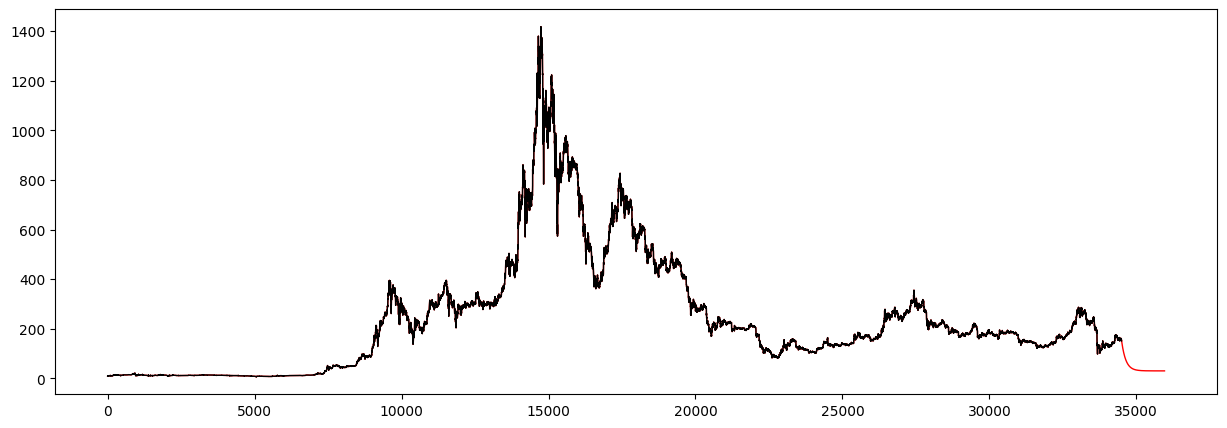

In [43]:
out = []
out = np.append(df.Close.values,new)
plt.figure(figsize=(15,5))
plt.plot(out,linewidth=1,color='red')
plt.plot(df.Close.values,linewidth=1,color='black')
plt.show()

In [44]:
len(out),len(df.Close)

(35961, 34497)